In [156]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from typing import Literal
from collections import defaultdict

sns.set_context("notebook")
sns.set_palette("deep")
color_palette = sns.color_palette()
color_palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [2]:
FDF_GRAIN_SIZE: Literal["url", "context", "program"] = "url"

In [3]:
OUT_PATH = Path('output')
IN_PATH = Path('input')

In [4]:
df_raw = pd.read_pickle(IN_PATH / 'df-all-merged-1.pkl.zstd', compression='zstd')
df_huls = df_raw[df_raw.gl_info.apply(lambda x: x['whenUsedWebgl'] is not None if x is not None else False)].copy()
# # `hundred_frames_status` start with skip
# # `hundred_frames_status` is "N/A"
# # `gl_info` is None
# supplement_url = sorted(set(pd.concat([
#     df_huls[df_huls['hundred_frames_status'].str.startswith('skip')],
#     # df_huls[df_huls['hundred_frames_status'] == 'N/A'],
#     # df_huls[df_huls['gl_info'].isnull()]
# ]).url))
# with open("tmp_supplement_url.txt", "w") as f:
#     f.write("\n".join(supplement_url))
# supplement_url
# def used_webgl(x):
#     return x is not None and x['whenUsedWebgl'] is not None
# def render_time(x):
#     if x is None or x['whenUsedWebgl'] is None or x['when'] is None:
#         return -1
#     return x['when'] - x['whenUsedWebgl']

# ok_df = df_huls[df_huls['gl_info'].map(used_webgl)]
# with open('ok_urls.txt', 'w') as f:
#     f.write("\n".join(ok_df.url))
# not_ok_df = df_huls[~df_huls['gl_info'].map(used_webgl)]
# with open('not_ok_urls.txt', 'w') as f:
#     f.write("\n".join(not_ok_df.url))
# err_df = df_huls[df_huls['gl_info'].isnull()]
# with open('err_urls.txt', 'w') as f:
#     f.write("\n".join(err_df.url))
# fast_df = df_huls[df_huls['gl_info'].map(render_time) < 10000]
# with open('fast_urls.txt', 'w') as f:
#     f.write("\n".join(fast_df.url))
df_huls.webgl_status.value_counts()

Ok                  5587
TimeoutException       2
Name: webgl_status, dtype: int64

In [5]:
df_raw.url.is_unique

True

In [6]:
gl_infos = df_huls['gl_info'].dropna().tolist()
print(len(gl_infos))

5589


In [7]:
with open(OUT_PATH / 'example' / 'gl_info.json', 'w') as fp:
    json.dump(gl_infos[0], fp, indent=2)

In [8]:
def get_canvas_length(gl_info):
    if gl_info is None:
        return 0
    return len(gl_info['contextInfo'])

In [9]:
df_huls['canvas_length'] = df_huls['gl_info'].map(get_canvas_length)

Figure out why a webpage contains more than one canvas. List some urls and their canvas counts.

In [10]:
df_huls[df_huls['canvas_length'] > 1][['url', 'canvas_length', 'gl_info']]

,url,canvas_length,gl_info
13,http://1j1d.art,4,"{'accessTime': 1679326485110, 'contextInfo': [..."
16,http://2016.makemepulse.com,5,"{'accessTime': 1679326466786, 'contextInfo': [..."
17,http://2016.makemepulse.com/,4,"{'accessTime': 1679326516003, 'contextInfo': [..."
24,http://2021.fanzone36.com,2,"{'accessTime': 1679326532913, 'contextInfo': [..."
25,http://20years.polymetalinternational.com/,2,"{'accessTime': 1679326603607, 'contextInfo': [..."
...,...,...,...
8577,https://zap.ramotion.agency,7,"{'accessTime': 1679417767017, 'contextInfo': [..."
8593,https://zestore.fr/,2,"{'accessTime': 1679417923090, 'contextInfo': [..."
8608,https://zoccon.me/,2,"{'accessTime': 1679414129739, 'contextInfo': [..."
8609,https://zoccon.me/https://tagree.agency/,2,"{'accessTime': 1679418080308, 'contextInfo': [..."


# In other words, could we detect the pattern of an empty canvas?

In [11]:
tmp = df_raw[df_raw['url'] == 'http://sonorannews.com'].gl_info.iloc[0]
open(OUT_PATH / 'example' / 'tmp.json', 'w').write(json.dumps(tmp, indent=2))

21044

# canvas sizes

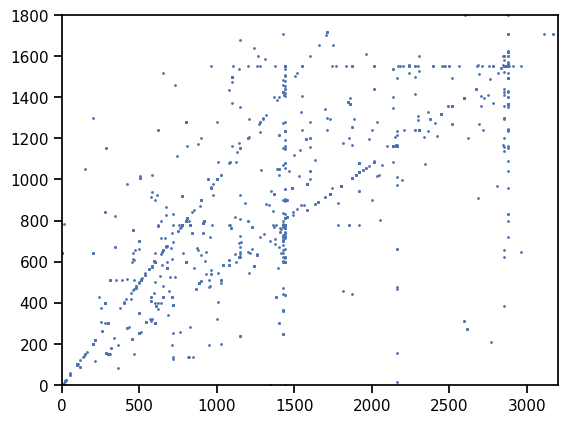

60

In [12]:
canvas_sizes = [y['canvasSize'] for x in gl_infos for y in x['contextInfo']]
# plot the distribution of canvas size( as scatter plot)
plt.scatter([x[0] for x in canvas_sizes], [x[1] for x in canvas_sizes], s=1)
plt.xlim(0, 3200)
plt.ylim(0, 1800)
plt.show()
# count the canvas which size is larger than 3200x1800
len([x for x in canvas_sizes if x[0] > 3200 or x[1] > 1800])

In [13]:
import re
def remove_whitespaces(s: str):
    return re.sub(r'\s+', '', s)

In [14]:
remove_whitespaces("t est\nHelloworl d")

'testHelloworld'

In [281]:
def extract_shaders(ctx_info, context_id=-1):
    ret = ([], []) # vert, frag
    for x in ctx_info['programInfo']:
        if x is None: continue
        for y in x['vertexShaders']:
            if type(y) != str:
                # print(ctx_info)
                pass
            else:
                ret[0].append([remove_whitespaces(y), y, ctx_info['url'], context_id])
        for y in x['fragmentShaders']:
            if type(y) != str:
                # print(ctx_info)
                pass
            else:
                ret[1].append([remove_whitespaces(y), y, ctx_info['url'], context_id])
    return ret

In [133]:
def flatten_ctx_info(ctx_info):
    ret = {}
    
    ret['url'] = ctx_info['url']
    ret['when'] = ctx_info['when']
    ret['accessTime'] = ctx_info['accessTime']
    ret['whenDomContentLoadedEvent'] = ctx_info['whenDomContentLoadedEvent']
    ret['whenLoadEvent'] = ctx_info['whenLoadEvent']
    ret['whenUsedWebgl'] = ctx_info['whenUsedWebgl']
    ret['contextType'] = ctx_info['maghsk']['createArguments'][0]
    if len(ctx_info['maghsk']['createArguments']) == 2:
        # print(ctx_info['maghsk']['createArguments'])
        if ctx_info['maghsk']['createArguments'][1] is not None:
            for k, v in ctx_info['maghsk']['createArguments'][1].items():
                ret['arg_{}'.format(k)] = v
    elif len(ctx_info['maghsk']['createArguments']) > 2:
        # print("ERROR", ctx_info['maghsk']['createArguments'])
        raise ValueError("ERROR", ctx_info['maghsk']['createArguments'])

    ret['rafCalled_total'] = ctx_info['rafCalled_total']
    ret['rafCalled_max'] = ctx_info['rafCalled_max']
    ret['vertexCount'] = ctx_info['vertexCount']
    ret['triangleCount'] = ctx_info['triangleCount']
    ret['extensions'] = sorted(x for x in set(ctx_info['extensions']) if x != 'GMAN_webgl_memory')
    
    # ret['canvas_hidden'] = ctx_info['canvasHidden']
    # ret['offscreen'] = ctx_info['maghsk']['isOffScreen']
    ret['program_use'] = 0 
    ret['program_count'] = 0
    for x in ctx_info['programInfo']:
        if x is None: continue
        ret['program_use'] += x['useCounts']
        ret['program_count'] += 1
    vert, frag = extract_shaders(ctx_info)
    ret['shader_length'] = sum(len(x[0]) for x in vert) + sum(len(x[0]) for x in frag)
    ret['shader_count'] = len(vert) + len(frag)

    mem_info = ctx_info['memoryInfo']
    memory = mem_info['memory']
    resources = mem_info['resources']
    for key, value in sorted(memory.items()):
        # if key == 'total':
        ret['_memory_' + key] = value
    for key, value in sorted(resources.items()):
        ret['_resources_' + key] = value
    
    func_count = ctx_info['maghsk']['funcCount']
    ret['total_func_call'] = 0
    ret['total_memory'] = memory['total']
    for key, value in sorted(func_count.items()):
        ret['_func_call_' + key] = value
        ret['total_func_call'] += value

    return ret

# Flatten ContextInfos

In [134]:
context_infos = []
for gl_info in gl_infos:
    for y in gl_info['contextInfo']:
        y['url'] = gl_info['url']
        y['when'] = gl_info['when']
        y['accessTime'] = gl_info['accessTime']
        y['whenDomContentLoadedEvent'] = gl_info['whenDomContentLoadedEvent']
        y['whenLoadEvent'] = gl_info['whenLoadEvent']
        y['whenUsedWebgl'] = gl_info['whenUsedWebgl']
        try:
            y['rafCalled_total'] = sum(gl_info['rafFuncCountList'])
            y['rafCalled_max'] = max(gl_info['rafFuncCountList'], default=0)
        except:
            print(gl_info['rafFuncCountList'])
            print(gl_info['url'])
            print(gl_info['whenUsedWebgl'])
            continue
        context_infos.append(y)
context_infos = sorted(context_infos, key=lambda x: sum(y for y in x['maghsk']['funcCount'].values()), reverse=True)

[[None]]
https://custom.gomezsimindustries.com/
898.2000000029802


In [135]:
# fcontext_infos = [flatten_ctx_info(x) for x in context_infos]
fcontext_infos = []
fdf_columns = set()
for x in context_infos:
    fcontext_infos.append(flatten_ctx_info(x))
    fdf_columns.update(flatten_ctx_info(x).keys())

fdf = pd.DataFrame(fcontext_infos)
# zip column name with dtype
for x in fdf.columns.tolist():
    print(x, fdf[x].dtype)

url object
when float64
accessTime int64
whenDomContentLoadedEvent float64
whenLoadEvent float64
whenUsedWebgl float64
contextType object
arg_alpha object
arg_antialias object
arg_depth object
arg_premultipliedAlpha object
arg_preserveDrawingBuffer object
arg_stencil object
rafCalled_total int64
rafCalled_max int64
vertexCount float64
triangleCount float64
extensions object
program_use int64
program_count int64
shader_length int64
shader_count int64
_memory_buffer int64
_memory_drawingbuffer int64
_memory_renderbuffer float64
_memory_texture float64
_memory_total float64
_resources_buffer int64
_resources_framebuffer int64
_resources_program int64
_resources_renderbuffer int64
_resources_shader int64
_resources_texture int64
total_func_call int64
total_memory float64
_func_call_activeTexture float64
_func_call_attachShader float64
_func_call_bindBuffer float64
_func_call_bindFramebuffer float64
_func_call_bindRenderbuffer float64
_func_call_bindTexture float64
_func_call_blendEquation 

In [136]:
fdf.fillna(0, inplace=True)
print((len(fdf[fdf['total_func_call'] == 0])))
fdf_url = fdf.groupby('url').aggregate(np.sum)
fdf = fdf[fdf['total_func_call'] > 0]
fdf_url[fdf_url['total_func_call'] == 0].to_csv(OUT_PATH / 'total_func_call_0.csv')
fdf_url[fdf_url['shader_count'] == 0].to_csv(OUT_PATH / 'shader_count_0.csv')
fdf_url[fdf_url['program_count'] == 1].to_csv(OUT_PATH / 'program_count_1.csv')
fdf_url[fdf_url['_memory_total'] == 0].to_csv(OUT_PATH / '_memory_total_0.csv')
fdf_url = fdf_url[fdf_url['total_func_call'] > 0]
fdf

3688


/var/folders/w6/d7548d750k38gs5srtc_217r0000gn/T/ipykernel_49272/3127469534.py:3: FutureWarning: The operation <function sum at 0x111325260> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  fdf_url = fdf.groupby('url').aggregate(np.sum)


,url,when,accessTime,whenDomContentLoadedEvent,whenLoadEvent,whenUsedWebgl,contextType,arg_alpha,arg_antialias,arg_depth,...,_func_call_isEnabled,_func_call_samplerParameterf,_func_call_samplerParameteri,arg_failIfMajorPerformanceCaviet,arg_transparent,_func_call_getUniform,arg_height,arg_width,arg_ignoreWebgl2,_func_call_isTexture
0,https://www.dangleterre.com/en/meetings-events...,47412.3,1679393271065,17586.4,17598.7,17216.7,webgl,False,True,True,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
1,http://127.0.0.1:8000/test1/webgl/hard,32861.5,1679326370599,695.0,695.2,231.7,webgl2,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
2,http://127.0.0.1:8000/test3/webgl/medium,31640.2,1679326403021,1228.5,1228.7,1024.6,webgl2,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
3,http://127.0.0.1:8000/test1/webgl/medium,31447.5,1679326372954,661.8,661.9,317.7,webgl2,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
4,https://www.boranka.hr/en,37150.4,1679394560031,6724.0,14520.5,6688.8,webgl,False,False,True,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5089,https://www.thefemalegaze.art/,35663.7,1679409879101,1669.1,4143.9,5179.8,webgl2,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
5090,https://www.thefemalegaze.art/,35663.7,1679409879101,1669.1,4143.9,5179.8,webgl2,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
5091,https://www.thefemalegaze.art/,35663.7,1679409879101,1669.1,4143.9,5179.8,webgl2,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
5092,https://www.thoughtlab.com/,33158.6,1679410205569,3097.2,8205.9,3069.0,webgl2,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0


In [137]:
len(fdf.url.unique())

2656

# Context Type

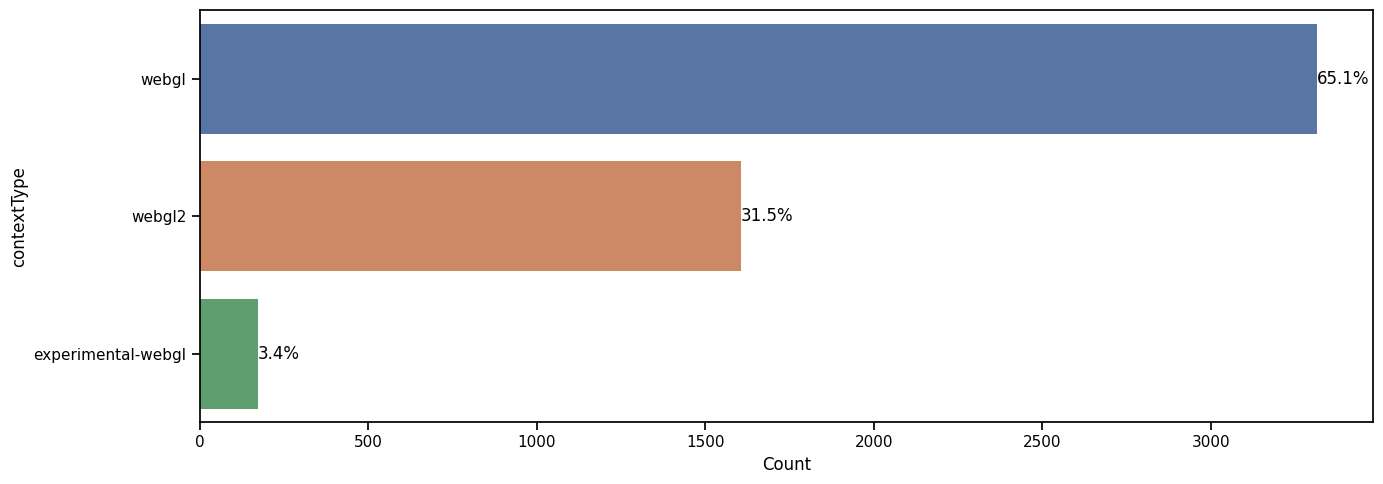

In [138]:
fig, axes = plt.subplots(figsize=(14, 5))

sns.countplot(y='contextType', data=fdf, ax=axes)
axes.set_xlabel('Count')
axes.set_ylabel('contextType')

for rect in axes.patches:
    axes.annotate(f'{rect.get_width()/len(fdf)*100:.1f}%', 
                        (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                        ha='left', va='center')

plt.tight_layout()
plt.show()

# Power Preference

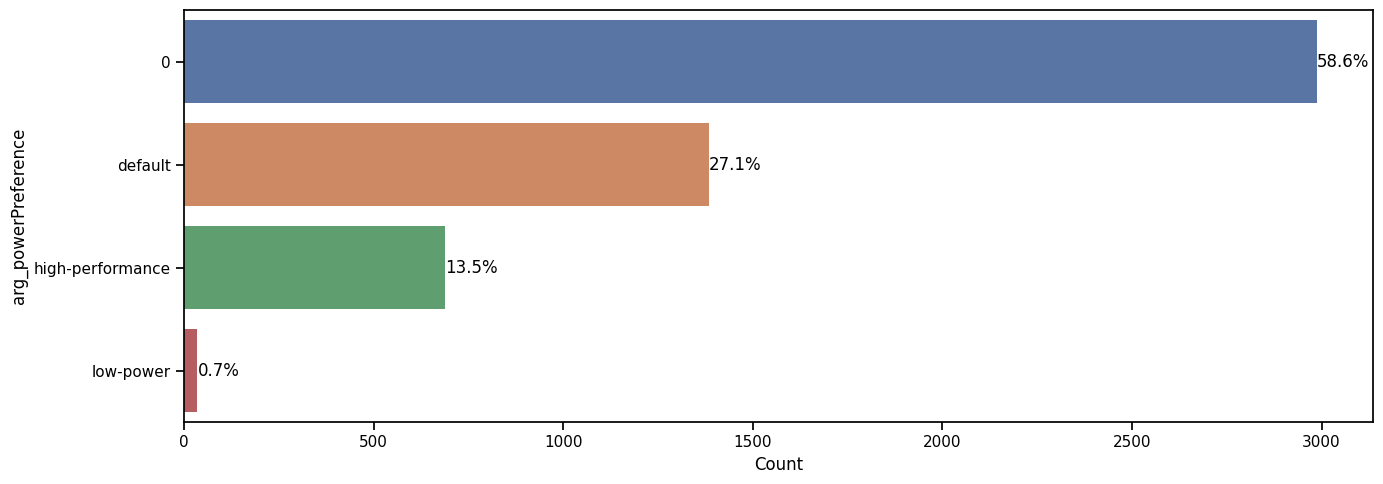

In [139]:
fig, axes = plt.subplots(figsize=(14, 5))

sns.countplot(y='arg_powerPreference', data=fdf, ax=axes)
axes.set_xlabel('Count')
axes.set_ylabel('arg_powerPreference')

for rect in axes.patches:
    axes.annotate(f'{rect.get_width()/len(fdf)*100:.1f}%', 
                        (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                        ha='left', va='center')

plt.tight_layout()
plt.show()

# Context Attrib

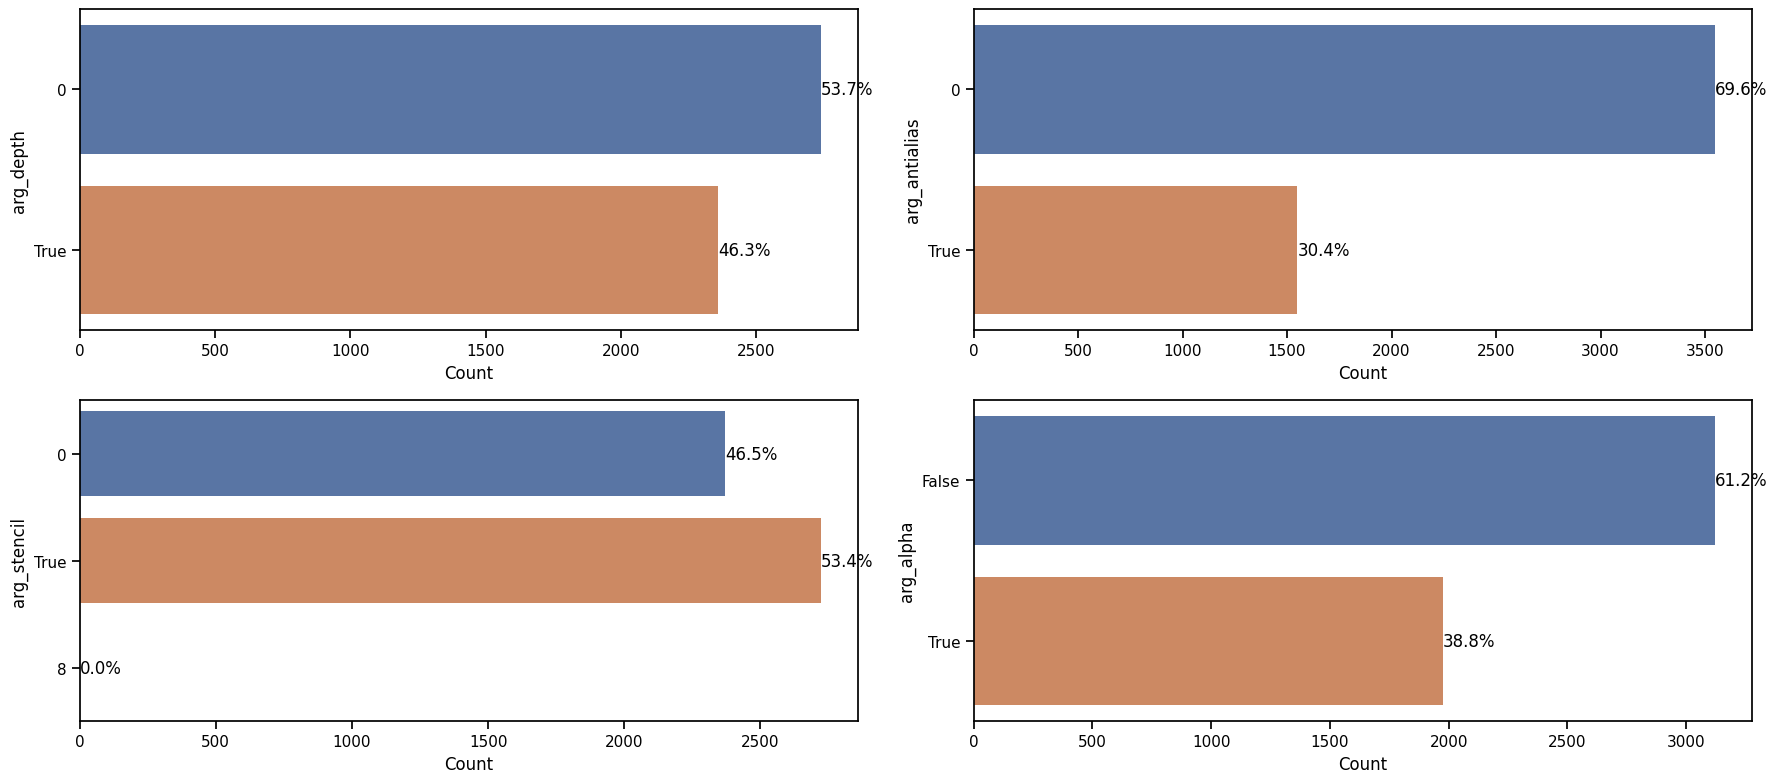

In [140]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 8))

sns.countplot(y='arg_depth', data=fdf, ax=axes[0,0])
axes[0,0].set_xlabel('Count')
axes[0,0].set_ylabel('arg_depth')

sns.countplot(y='arg_antialias', data=fdf, ax=axes[0,1])
axes[0,1].set_xlabel('Count')
axes[0,1].set_ylabel('arg_antialias')

sns.countplot(y='arg_stencil', data=fdf, ax=axes[1,0])
axes[1,0].set_xlabel('Count')
axes[1,0].set_ylabel('arg_stencil')

sns.countplot(y='arg_alpha', data=fdf, ax=axes[1,1])
axes[1,1].set_xlabel('Count')
axes[1,1].set_ylabel('arg_alpha')

for x in range(2):
    for y in range(2):
        for rect in axes[x,y].patches:
            axes[x,y].annotate(f'{rect.get_width()/len(fdf)*100:.1f}%', 
                                (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                                ha='left', va='center')

plt.tight_layout()
plt.show()

In [141]:
(fdf.when - fdf.whenUsedWebgl).describe()

count      5094.000000
mean      31057.457805
std        5799.211129
min          56.300000
25%       30139.150000
50%       30264.750000
75%       30401.500000
max      109700.600000
dtype: float64

# Extensions

In [142]:
tmp = fdf.extensions.apply(len)
print("percentage of context which has no extension: {:.2f}%".format((tmp == 0).sum() / len(tmp) * 100))

percentage of context which has no extension: 10.01%


In [143]:
with open('input/webgl-extension-categories.json', 'r') as fp:
    category_to_extension = json.load(fp)

extension_to_category = defaultdict(lambda: 'unknown')
for category, extensions in category_to_extension.items():
    for extension in extensions:
        extension_to_category[extension] = category

In [144]:
extension_to_category['233']

'unknown'

count                          4584
unique                          238
top       WEBGL_debug_renderer_info
freq                           1062
Name: extensions, dtype: object


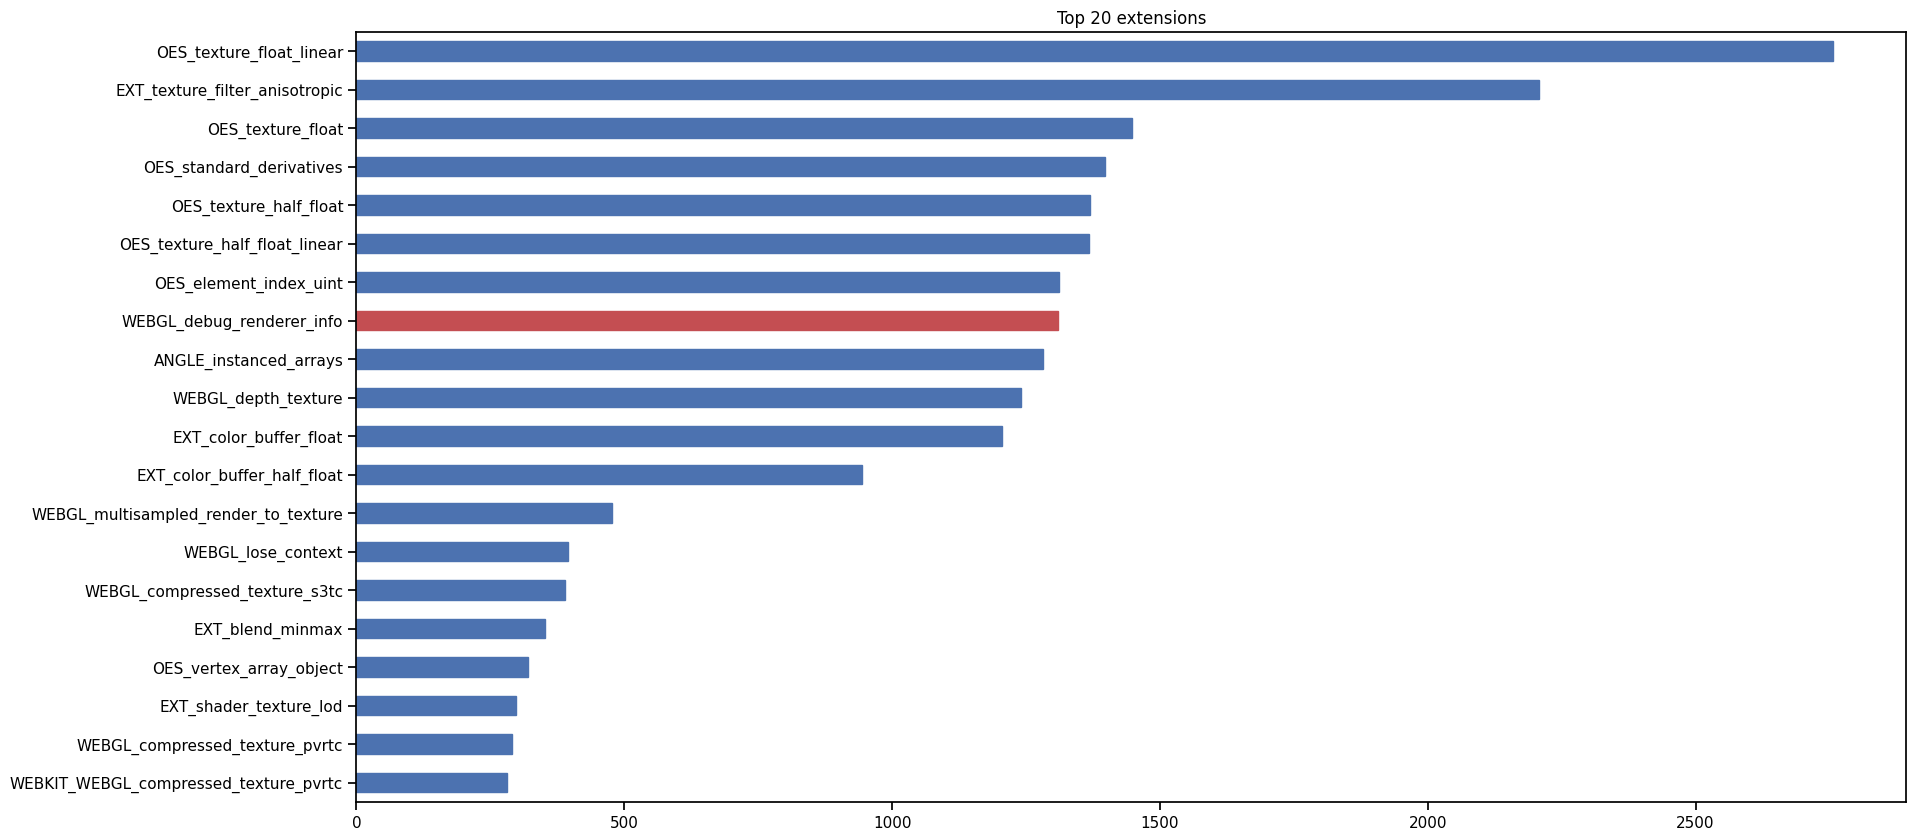

In [145]:
extension = fdf[fdf.extensions.apply(len) > 0].extensions
tmp = extension.apply(lambda x: ';'.join(x)).value_counts().to_dict()
json.dump(tmp, open(OUT_PATH / 'example' / 'extension-count.json', 'w'), indent=2)
tmp2 = extension.apply(lambda x: ';'.join(x)).describe()
print(tmp2)
words_list = tmp2['top'].split(';')
tmp2 = []
for lst in extension:
    tmp2.extend(lst)

extension_df = pd.DataFrame({
    'name': pd.Series(tmp2),
    'category': pd.Series([extension_to_category[x] for x in tmp2]),
    'prefix': pd.Series([x.split('_')[0] for x in tmp2])
})
extension_df = extension_df[(extension_df['prefix'].str.len() > 2) & (extension_df['prefix'].str.upper() == extension_df['prefix'])]

tmp = extension_df['name'].value_counts(ascending=True)
# print(tmp.to_dict())
to_plot = tmp.iloc[len(tmp)-20:]
bar = to_plot.plot.barh(figsize=(20, 10))
for i, v in enumerate(to_plot.index):
    if v in words_list:
        bar.get_children()[i].set_color(sns.color_palette()[3])
    else:
        bar.get_children()[i].set_color(sns.color_palette()[0])
plt.title('Top 20 extensions')
plt.show()

In [162]:
sorted(set(extension_df[extension_df['category'] == 'unknown'].name))

['EXT_color_buffer_float_linear',
 'EXT_draw_buffers',
 'EXT_multisampled_render_to_texture',
 'MOZ_EXT_texture_filter_anisotropic',
 'MOZ_OES_texture_half_float_linear',
 'MOZ_OES_vertex_array_object',
 'MOZ_WEBGL_compressed_texture_astc',
 'MOZ_WEBGL_compressed_texture_atc',
 'MOZ_WEBGL_compressed_texture_etc',
 'MOZ_WEBGL_compressed_texture_etc1',
 'MOZ_WEBGL_compressed_texture_pvrtc',
 'MOZ_WEBGL_depth_texture',
 'OCULUS_multiview',
 'OES_float_linear',
 'OES_seamless_cube_map',
 'WEBGL_compressed_texture_es3',
 'WEBGL_compressed_texture_es3_0',
 'WEBGL_multisampled_render_to_texture',
 'WEBKIT_EXT_texture_compression_bptc',
 'WEBKIT_EXT_texture_filter_anisotropic',
 'WEBKIT_OES_texture_half_float_linear',
 'WEBKIT_OES_vertex_array_object',
 'WEBKIT_WEBGL_compressed_texture_astc',
 'WEBKIT_WEBGL_compressed_texture_atc',
 'WEBKIT_WEBGL_compressed_texture_etc',
 'WEBKIT_WEBGL_compressed_texture_etc1',
 'WEBKIT_WEBGL_compressed_texture_pvrtc',
 'WEBKIT_WEBGL_compressed_texture_s3tc',


In [147]:
extension_df['category'].value_counts()

Khronos ratified WebGL Extensions      17976
Community approved WebGL Extensions     3886
unknown                                 1112
Rejected WebGL Extensions                 94
Draft WebGL Extensions                     4
Name: category, dtype: int64

## Extension 开发过程

Extension 在其发展过程中经历了四个阶段：建议、草案、社区批准和Khronos批准。每个 extension 都应该推进到Khronos的批准。如果一个 extension 不能通过 extension 过程来推进，它可以被拒绝。

- Proposed extensions 是为了在公共WebGL邮件列表中进行讨论，以便进入草案状态；它们不应该被实现，即使是在供应商的前缀下。如果在社区中达成了共识，该 extension 就可以转为草案状态。
- Draft extensions 可以在供应商的前缀下实现，或者在运行时选项后面实现，以达到实验的目的，以便在最终确定 extension 之前获得经验。草案 extension 不应默认由WebGL实现来公开。一旦在社区中达成共识，该 extension 就可以转为Community approved 状态。
- Community approved extensions 应该在没有供应商前缀的情况下实现。当一个 extension 草案转为社区认可状态时，任何现有的实现都应该立即取消对任何厂商前缀的 extension 名称的支持。一旦被厂商实现，除非该 extension 存在严重问题，如安全漏洞，否则不应取消支持。
- Khronos ratified extensions 是那些经过Khronos委员会投票通过的Community approved extension 。
- Rejected extensions（不应被实现）。扩展进入被拒绝状态是因为在提议阶段没有达成共识或在草案阶段实施过程中出现技术困难。只有在特殊情况下，社区批准的扩展才能被拒绝。Khronos认可的扩展不能被拒绝。

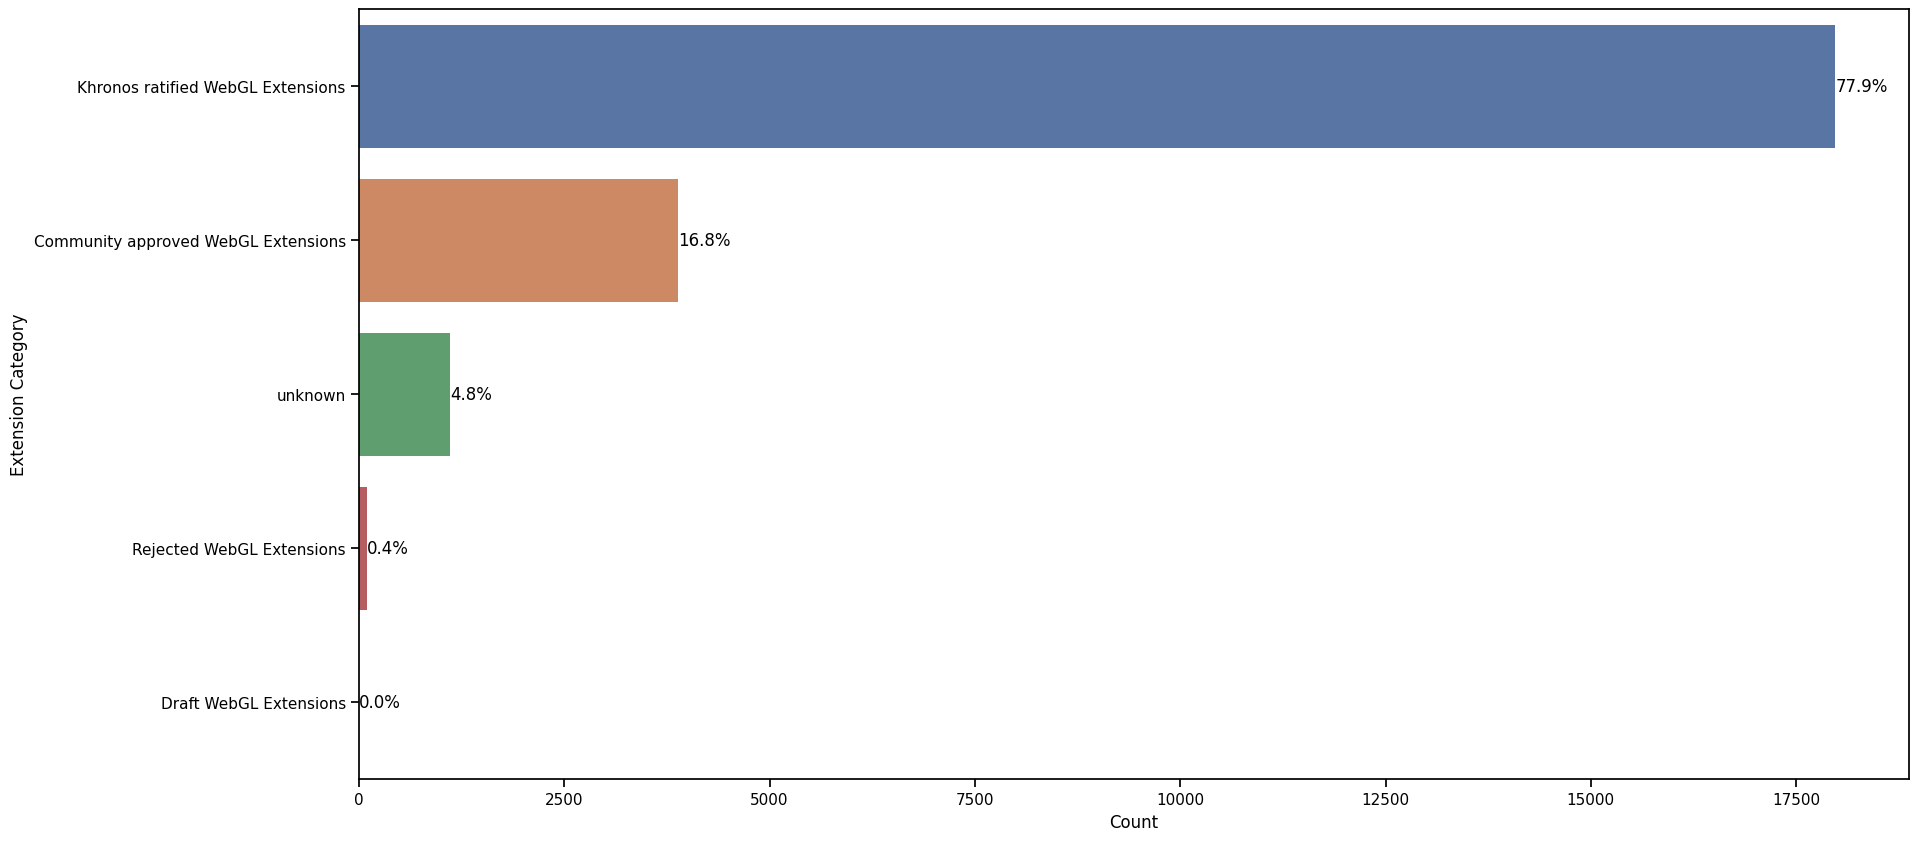

In [148]:
# extension_category.value_counts().plot.barh(figsize=(20, 10))
# with percentage
fig, axes = plt.subplots(figsize=(20, 10))
sns.countplot(y=extension_df['category'], ax=axes)
axes.set_xlabel('Count')
axes.set_ylabel('Extension Category')
for rect in axes.patches:
    axes.annotate(f'{rect.get_width()/len(extension_df)*100:.1f}%', 
                        (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                        ha='left', va='center')
plt.show()


## 命名约定

WebGL 扩展以“ANGLE”、“OES”、“EXT”、“WEBGL”为前缀。这些前缀反映了来源和意图：

- `ANGLE_`: 由 ANGLE library 的作者编写的扩展。
- `OES_` 和 `KHR_`: 由各自的架构审查委员会（Khronos）批准的对 OpenGL ES（OES）或 OpenGL API 扩展的功能的镜像。
- `OVR_`: 针对虚拟现实进行优化的扩展。
- `EXT_`: 从其他 OpenGL ES 或 OpenGL API 扩展镜像的扩展。
- `WEBGL_`: 特定于 WebGL 的扩展，旨在与多种 Web 浏览器兼容。它也应该用于源自 OpenGL ES 或 OpenGL API 的扩展，但其行为已被显著改变。

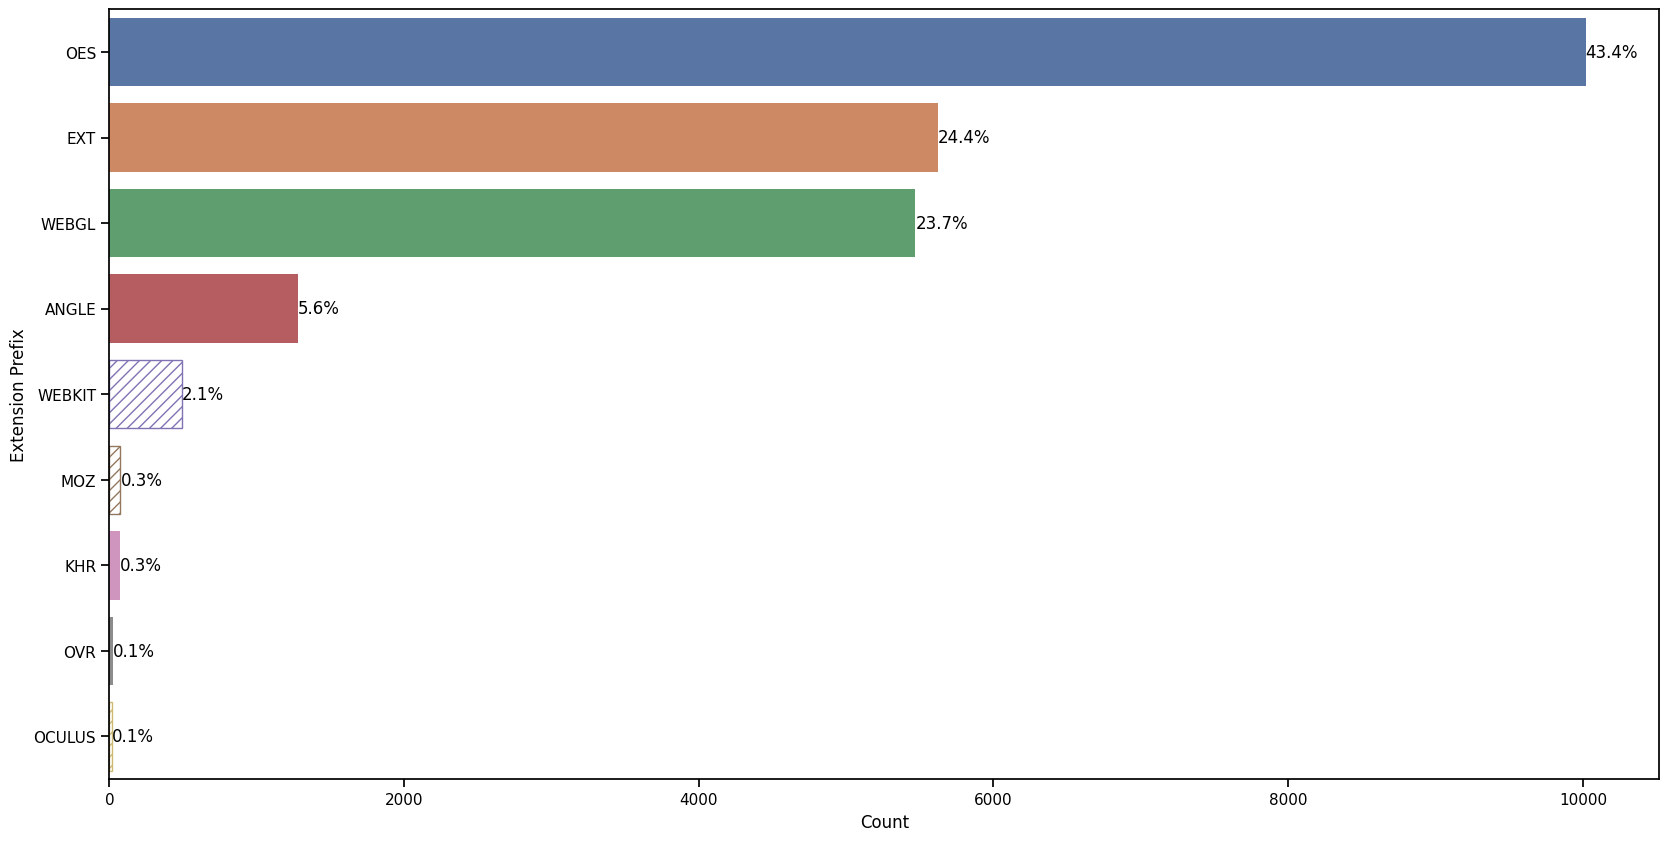

In [160]:
# extension_category.value_counts().plot.barh(figsize=(20, 10))
# with percentage
fig, axes = plt.subplots(figsize=(20, 10))
sns.countplot(y=extension_df['prefix'], ax=axes, order=extension_df['prefix'].value_counts().index)
axes.set_xlabel('Count')
axes.set_ylabel('Extension Prefix')
for rect in axes.patches:
    axes.annotate(f'{rect.get_width()/len(extension_df)*100:.1f}%', 
                        (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                        ha='left', va='center')
# hatch='///' on MOZ WEBKIT OCULUS
for i in [4,5,8]:
    axes.patches[i].set_hatch('///')
    axes.patches[i].set_facecolor('white')
    axes.patches[i].set_edgecolor(color_palette[i])
plt.show()

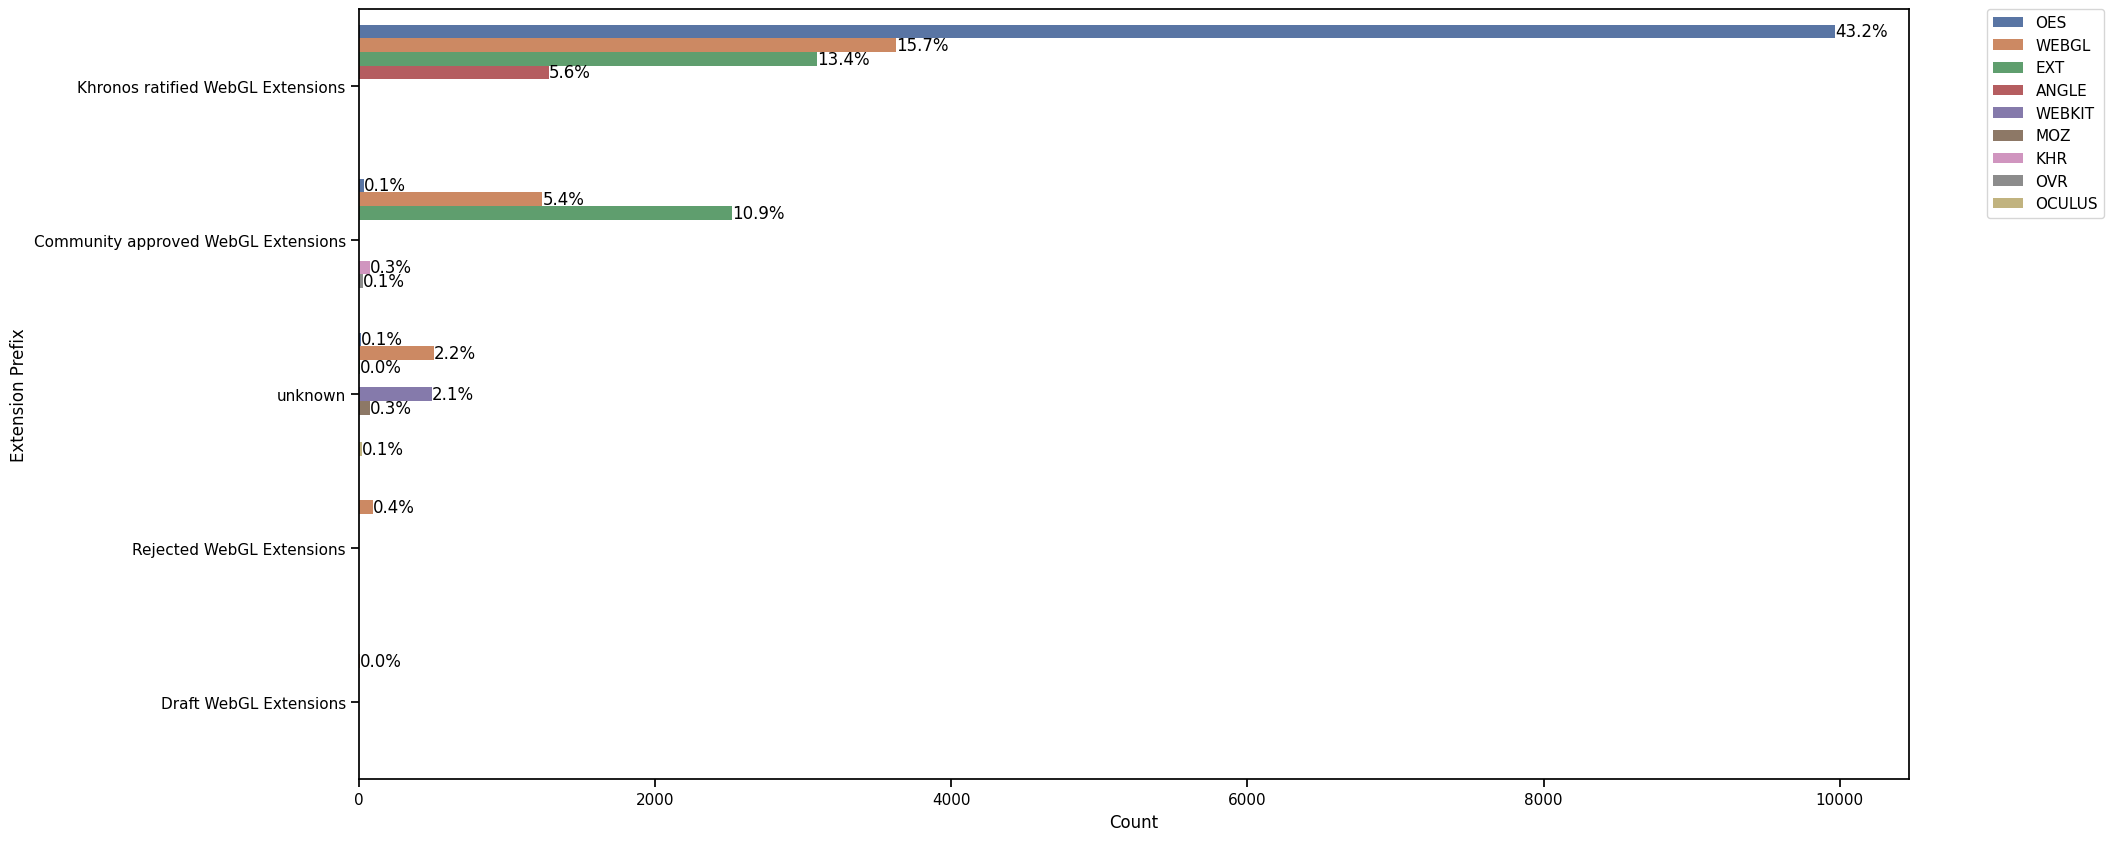

In [150]:
fig, axes = plt.subplots(figsize=(20, 10))
tmp = extension_df.value_counts(subset=['prefix', 'category'])
tmp = tmp.reset_index()
tmp.columns = ['prefix', 'category', 'count']
tmp
sns.barplot(x='count', y='category', hue='prefix', data=tmp, ax=axes)
axes.set_xlabel('Count')
axes.set_ylabel('Extension Prefix')
for rect in axes.patches:
    axes.annotate(f'{rect.get_width()/len(extension_df)*100:.1f}%', 
                        (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                        ha='left', va='center')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [60]:
tmp = extension.apply(lambda x: ';'.join(x))
fdf[fdf.extensions.apply(len) > 0][tmp.str.contains('BdwhLT1F')]

,url,when,accessTime,whenDomContentLoadedEvent,whenLoadEvent,whenUsedWebgl,contextType,arg_alpha,arg_antialias,arg_depth,...,_func_call_isEnabled,_func_call_samplerParameterf,_func_call_samplerParameteri,arg_failIfMajorPerformanceCaviet,arg_transparent,_func_call_getUniform,arg_height,arg_width,arg_ignoreWebgl2,_func_call_isTexture
3808,https://letidor.ru/age/podrostki,32775.4,1679367424727,3096.9,25632.0,2614.5,webgl,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
3809,https://letidor.ru/age/podrostki,32775.4,1679367424727,3096.9,25632.0,2614.5,webgl,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0


In [27]:
extension.describe()

count                            4623
unique                            248
top       [WEBGL_debug_renderer_info]
freq                             1046
Name: extensions, dtype: object

# WebGL calls

count    5.094000e+03
mean     2.154158e+05
std      1.443208e+06
min      1.000000e+00
50%      5.770000e+02
75%      4.342925e+04
90%      3.195791e+05
95%      7.432957e+05
99%      3.676318e+06
max      4.989299e+07
Name: total_func_call, dtype: float64


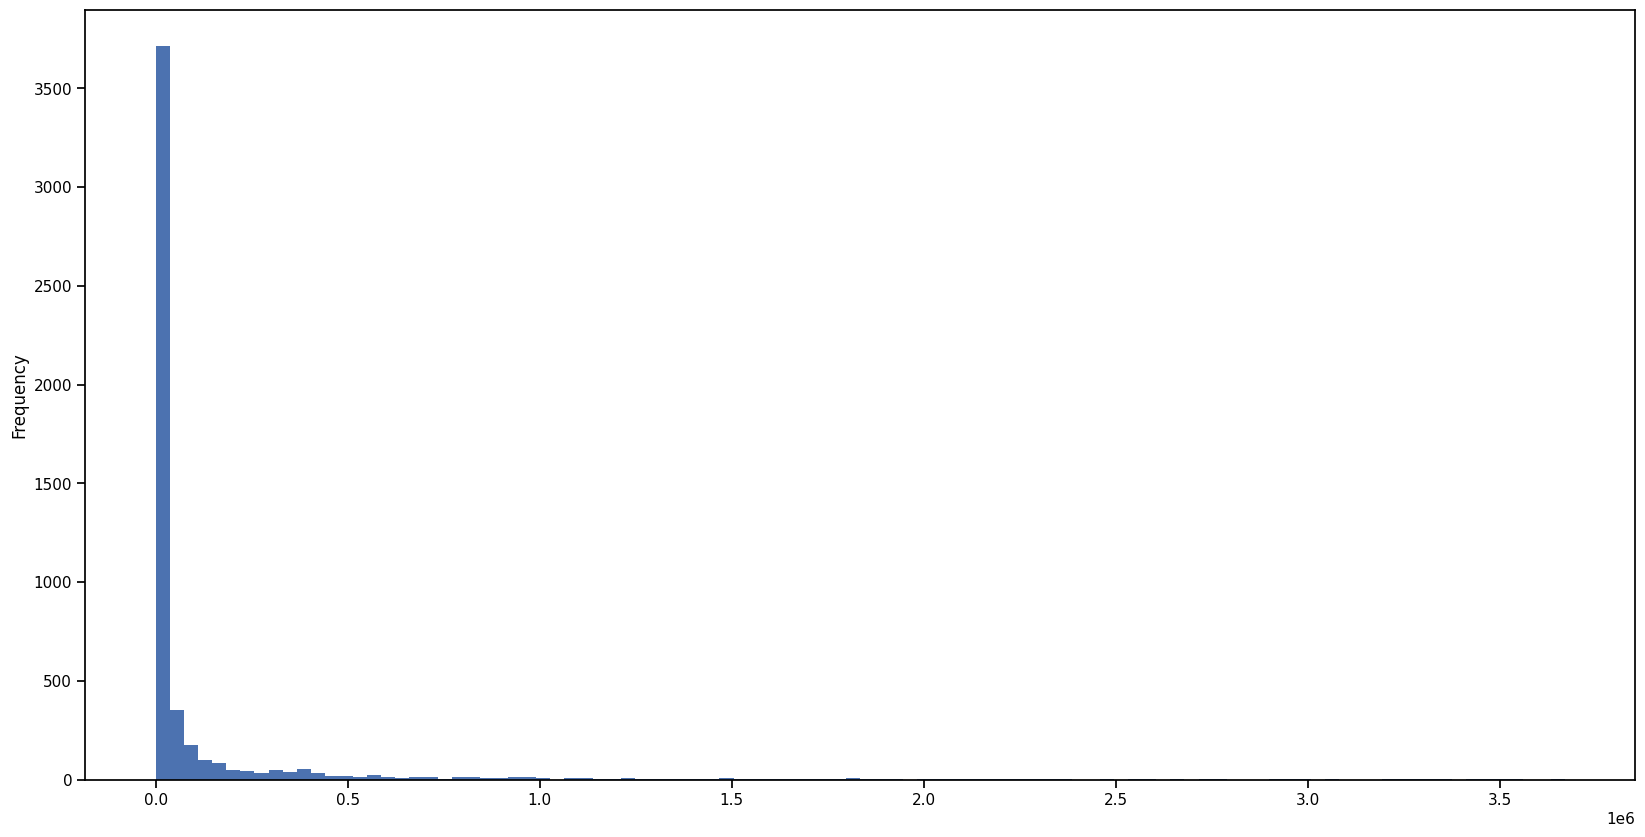

In [28]:
print(fdf['total_func_call'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))
# fdf[fdf['total_func_call'] < 100].total_func_call.value_counts().sort_index().plot(kind='bar', figsize=(20, 10))
fdf[fdf.total_func_call < fdf.total_func_call.quantile(0.99)].total_func_call.plot(kind='hist', bins=100, figsize=(20, 10))
plt.show()

# shader!

In [282]:
vert_shader_list = []
frag_shader_list = []
fdf_columns = set()
for i, x in enumerate(context_infos):
    vert, frag = extract_shaders(x, i)
    vert_shader_list.extend(vert)
    frag_shader_list.extend(frag)
vert_df = pd.DataFrame(vert_shader_list, columns=['source', 'original', 'url', 'context_id'])
frag_df = pd.DataFrame(frag_shader_list, columns=['source', 'original', 'url', 'context_id'])
vert_df['type'] = 'vert'
frag_df['type'] = 'frag'
shader_df = pd.concat([vert_df, frag_df])
shader_df['source_length'] = shader_df.source.apply(len)
shader_df

,source,original,url,context_id,type,source_length
0,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,11123
1,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,6542
2,precisionhighpfloat;uniformmat4modelViewMatrix...,precision highp float;\nuniform mat4 modelView...,https://www.dangleterre.com/en/meetings-events...,0,vert,635
3,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,6556
4,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,11136
...,...,...,...,...,...,...
22447,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main() {gl_FragColor = vec4(1,0,0,1);}",http://vulkanbet.com/en/goodbye-notice,3449,frag,39
22448,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main() {gl_FragColor = vec4(1,0,0,1);}",http://vulkanbet.com/en/goodbye-notice,3450,frag,39
22449,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main() {gl_FragColor = vec4(1,0,0,1);}",http://vulkanbet.com/en/goodbye-notice,3451,frag,39
22450,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main() {gl_FragColor = vec4(1,0,0,1);}",http://vulkanbet.com/en/goodbye-notice,3452,frag,39


In [221]:
tmp = OUT_PATH / 'example' / 'sampled_shaders'
for context_id, row in shader_df.sample(10).iterrows():
    shader = row.original
    typ = row.type
    with open(tmp / f'{context_id}.{typ}', 'w') as f:
        f.write(shader)

## Diversity of shaders

In [223]:
# group by source and count the different urls
tmp = shader_df.groupby('source').url.count()
shader_df['duplicate_ratio'] = shader_df.source.apply(lambda x: tmp[x])

shader_df

,source,original,url,type,source_length,duplicate_ratio
0,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,vert,11123,1
1,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,vert,6542,1
2,precisionhighpfloat;uniformmat4modelViewMatrix...,precision highp float;\nuniform mat4 modelView...,https://www.dangleterre.com/en/meetings-events...,vert,635,32
3,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,vert,6556,1
4,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,vert,11136,1
...,...,...,...,...,...,...
22447,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main() {gl_FragColor = vec4(1,0,0,1);}",http://vulkanbet.com/en/goodbye-notice,frag,39,28
22448,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main() {gl_FragColor = vec4(1,0,0,1);}",http://vulkanbet.com/en/goodbye-notice,frag,39,28
22449,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main() {gl_FragColor = vec4(1,0,0,1);}",http://vulkanbet.com/en/goodbye-notice,frag,39,28
22450,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main() {gl_FragColor = vec4(1,0,0,1);}",http://vulkanbet.com/en/goodbye-notice,frag,39,28


In [225]:
# group by source and count the different urls
tmp = shader_df['duplicate_ratio']
# bar without x axis name
print(tmp.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))
# lst = tmp.sort_values(ascending=False).to_list()
# fig, axes = plt.subplots(figsize=(20, 10))
# axes.plot(lst)
# axes.set_xlabel('Shader')
# axes.set_ylabel('Number of URLs')
# plt.show()
# tmp.sort_values(ascending=False).head(50).plot(kind='bar', figsize=(20, 10))

count    44904.000000
mean       165.363086
std        464.569091
min          1.000000
50%          4.000000
75%         45.000000
90%        290.000000
95%       1746.000000
99%       1746.000000
max       1746.000000
Name: duplicate_ratio, dtype: float64


### Context Level

<Axes: title={'center': 'By context'}, xlabel='Shader ID', ylabel='Number of Contexts'>

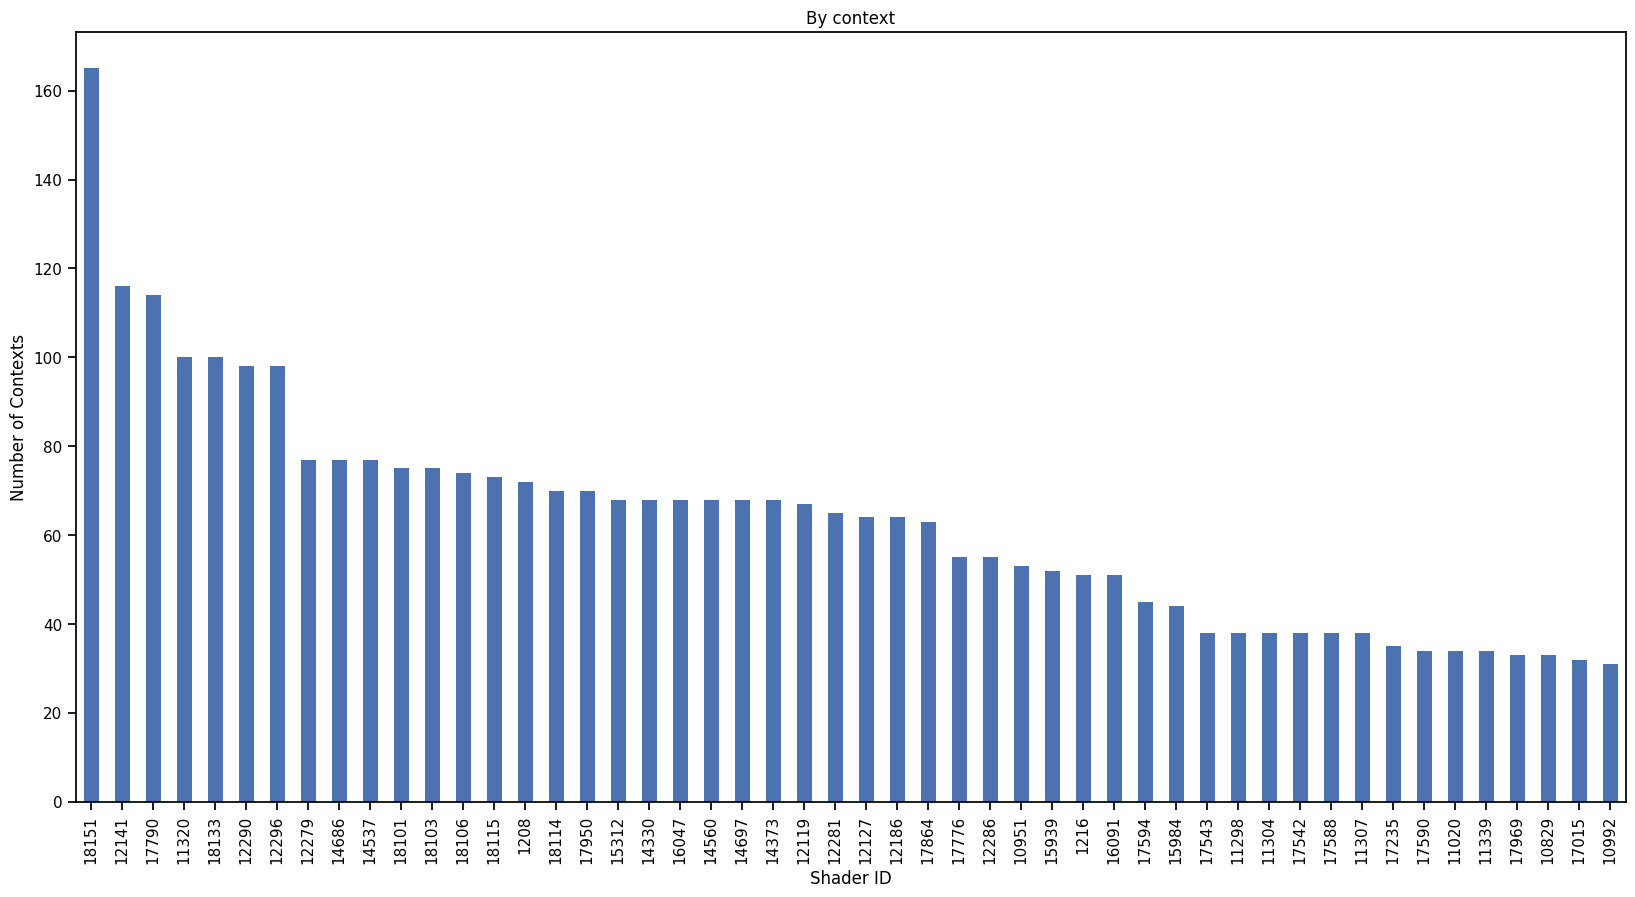

In [287]:
# group by source and count the different urls
tmp = shader_df.groupby('source').context_id.nunique()
# get shader length
tmp_df = pd.DataFrame(tmp).reset_index()
tmp_df['length'] = tmp_df.source.apply(len)
tmp_df.columns = ['source', 'context_count', 'length']
plt.title("By context")
plt.xlabel('Shader ID')
plt.ylabel('Number of Contexts')
tmp_df.sort_values('context_count', ascending=False).head(50).context_count.plot(kind='bar', figsize=(20, 10))


In [289]:
# group by source and count the different urls
tmp = shader_df.groupby('source').url.nunique()
# get shader length
tmp_df = pd.DataFrame(tmp).reset_index()
tmp_df['length'] = tmp_df.source.apply(len)
tmp_df.columns = ['source', 'url_count', 'length']
tmp_df


,source,url_count,length
0,#defineA3.141592653589793precisionhighpfloat;u...,1,1395
1,#defineA3.141592653589793uniformmat4projection...,1,528
2,#defineALPHA_TEST0.001#defineGLSLIFY1attribute...,1,745
3,#defineALPHA_TEST0.001#ifdefGL_OES_standard_de...,1,1560
4,#defineALPHA_TEST0.5#defineMAX_BONES65#defineU...,1,598
...,...,...,...
18211,varyingvec2vUv;uniformmat4modelViewMatrix;unif...,2,2034
18212,varyingvec3vNormal;attributevec2uv;attributeve...,1,482
18213,"voidmain(){gl_FragColor=vec4(1,0,0,1);}",9,39
18214,"voidmain(){if(length(gl_PointCoord-vec2(0.5,0....",1,99


In [290]:
# merge shader_df.type on source
tmp_df = tmp_df.merge(shader_df[['source', 'type']], on='source', how='left')
tmp_df = tmp_df.drop_duplicates(subset=['source'])
tmp_df

,source,url_count,length,type
0,#defineA3.141592653589793precisionhighpfloat;u...,1,1395,frag
1,#defineA3.141592653589793uniformmat4projection...,1,528,vert
2,#defineALPHA_TEST0.001#defineGLSLIFY1attribute...,1,745,vert
4,#defineALPHA_TEST0.001#ifdefGL_OES_standard_de...,1,1560,frag
6,#defineALPHA_TEST0.5#defineMAX_BONES65#defineU...,1,598,vert
...,...,...,...,...
44871,varyingvec2vUv;uniformmat4modelViewMatrix;unif...,2,2034,vert
44873,varyingvec3vNormal;attributevec2uv;attributeve...,1,482,vert
44874,"voidmain(){gl_FragColor=vec4(1,0,0,1);}",9,39,frag
44902,"voidmain(){if(length(gl_PointCoord-vec2(0.5,0....",1,99,frag


In [291]:
# bar without x axis name
print(tmp_df.url_count.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))
tmp = tmp_df.sort_values(by='url_count', ascending=False).head(50)
tmp

count    18216.000000
mean         1.348210
std          2.646221
min          1.000000
50%          1.000000
75%          1.000000
90%          1.000000
95%          2.000000
99%          8.000000
max        105.000000
Name: url_count, dtype: float64


,source,url_count,length,type
44509,precisionmediumpfloat;varyingvec4vColor;voidma...,105,76,frag
21970,attributevec2attrVertex;varyingvec2varyinTexCo...,73,170,vert
44284,precisionmediumpfloat;varyingvec2varyinTexCoor...,73,108,frag
25221,precisionhighpfloat;attributevec2aVertexPositi...,69,342,vert
25561,precisionhighpfloat;attributevec2aVertexPositi...,69,323,vert
3643,#definen20precisionmediumpfloat;precisionmediu...,65,756,vert
43113,precisionmediumpfloat;precisionmediumpint;attr...,63,746,vert
24171,precisionhighpfloat;#defineSHADER_NAMEpixi-sha...,58,488,vert
23993,precisionhighpfloat;#defineSHADER_NAMEpixi-sha...,58,373,vert
42398,precisionmediumpfloat;#defineSHADER_NAMEpixi-s...,57,1278,frag


In [292]:
tmp['index'] = tmp.index

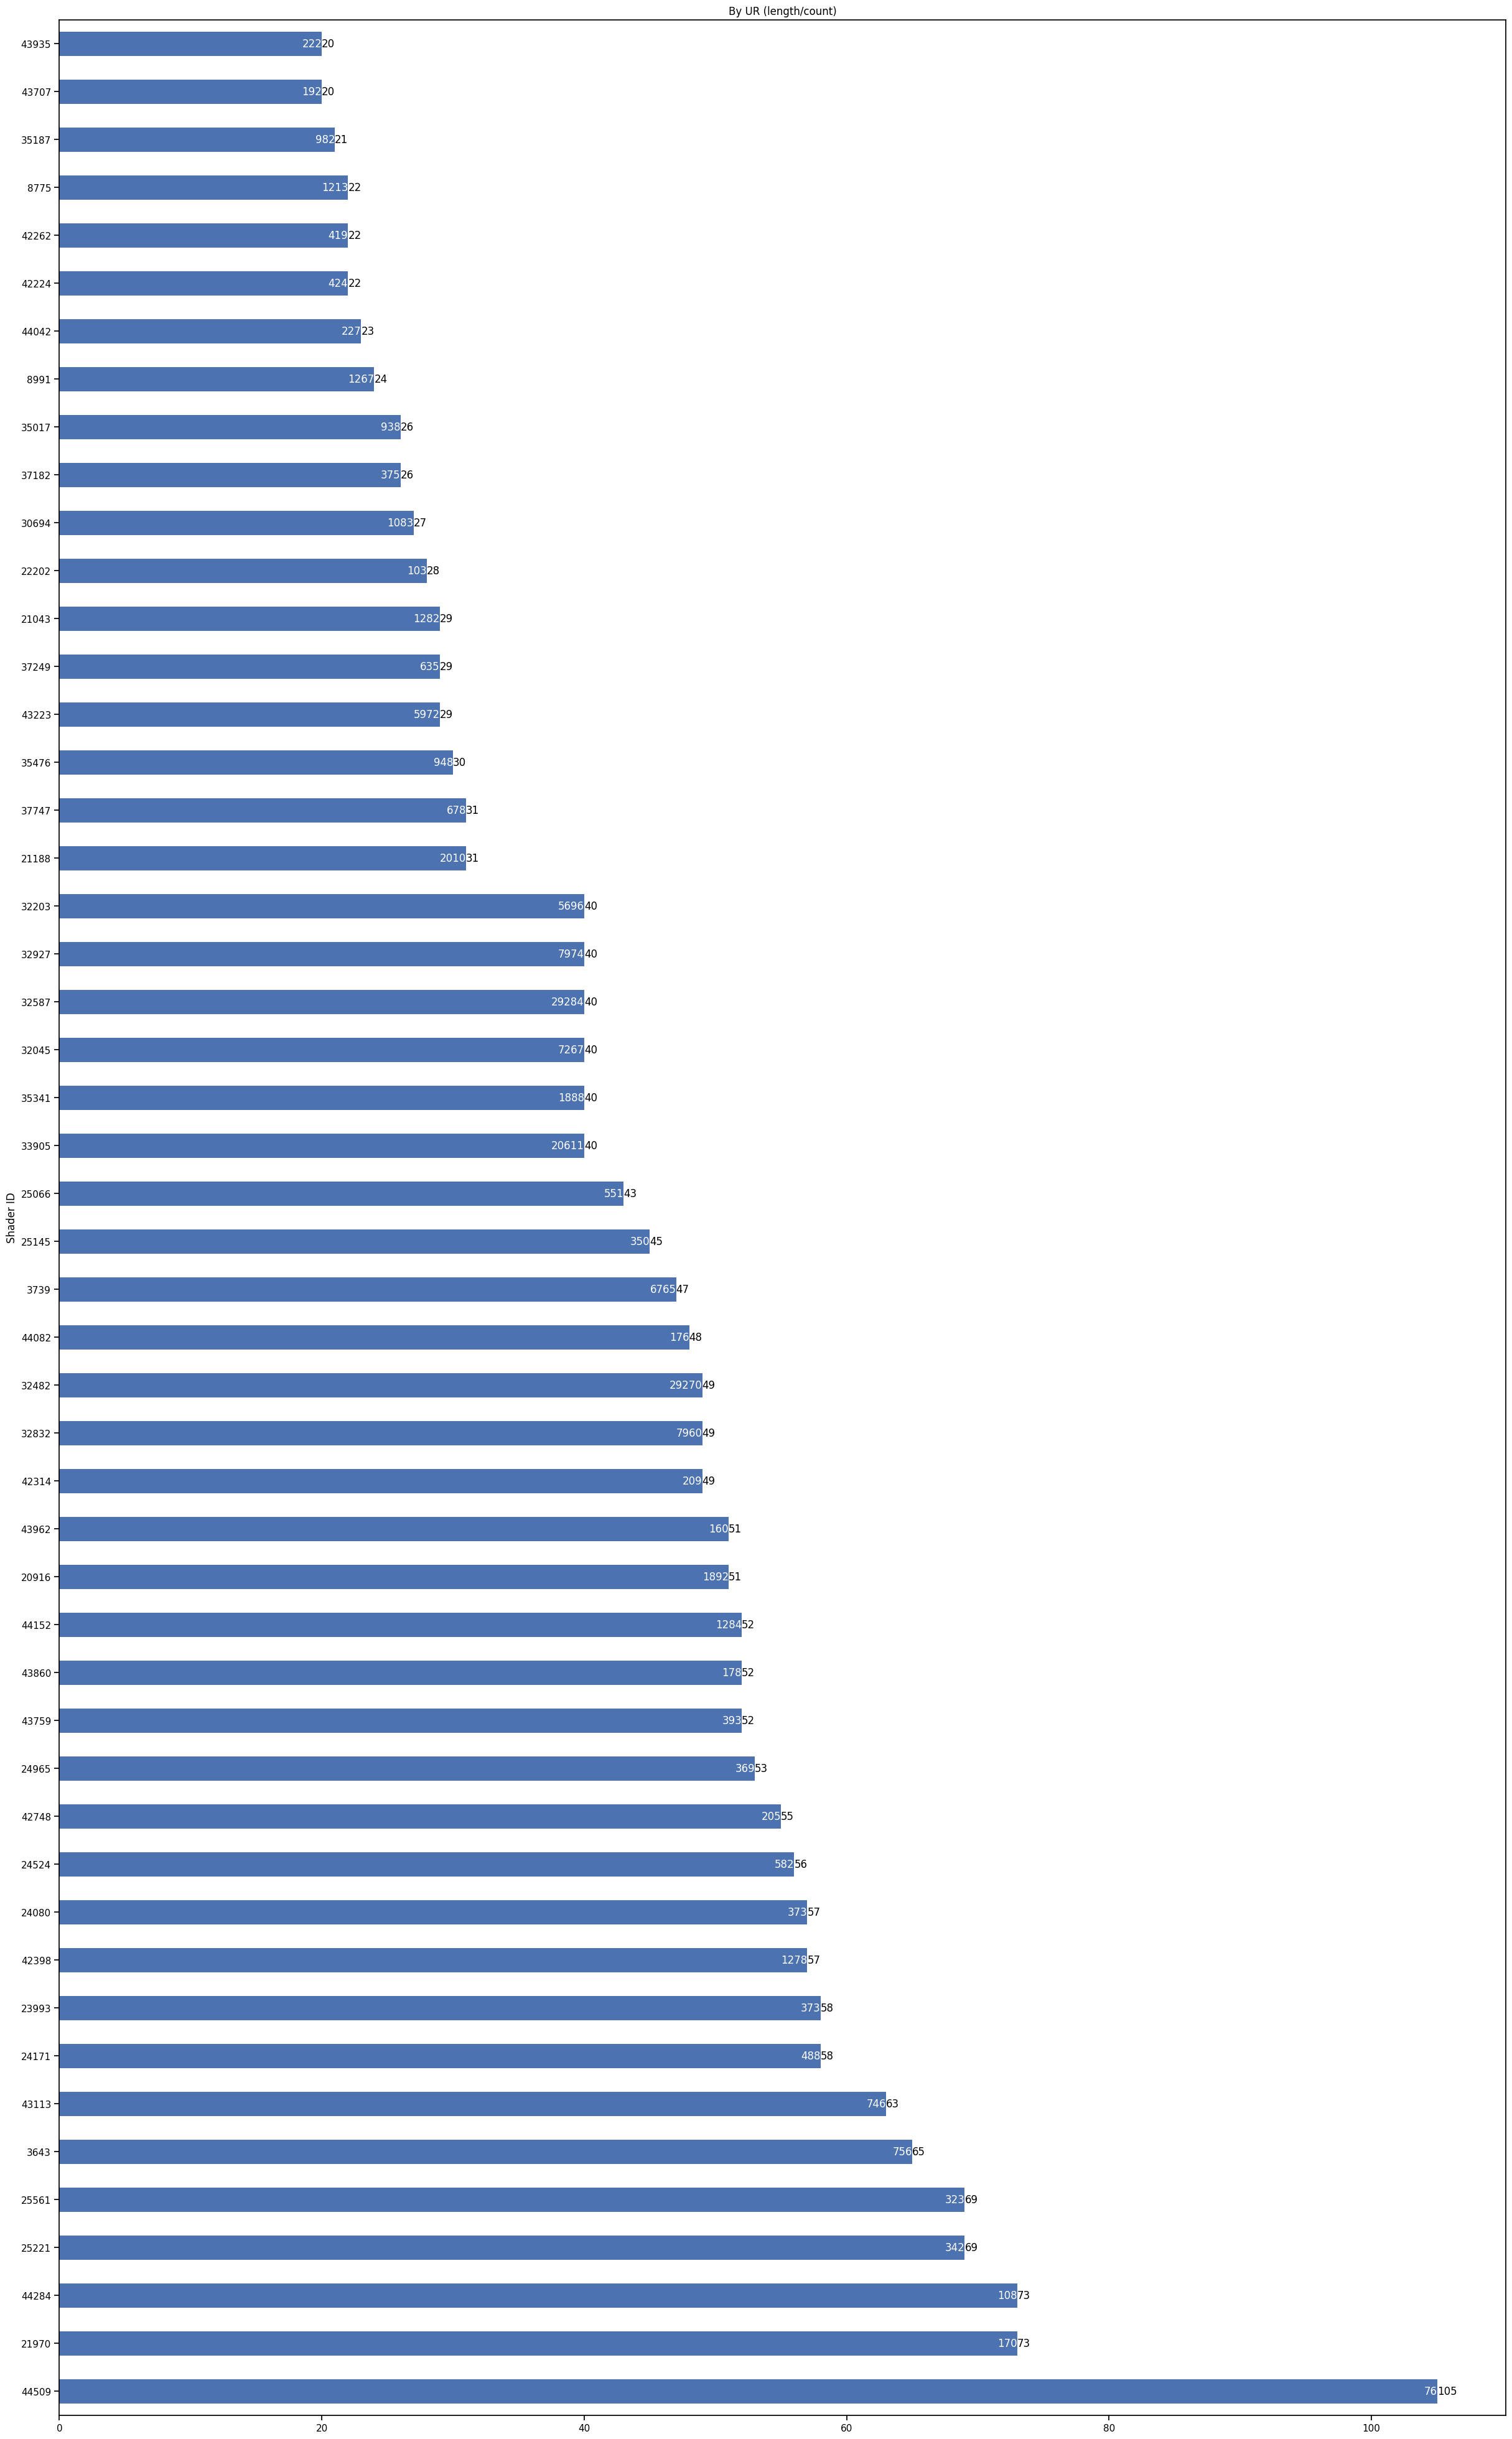

In [297]:
# plt.figure(figsize=(30, 50))
plt.title("By UR (length/count)")
plt.xlabel('Number of URLs')
plt.ylabel('Shader ID')
bar = tmp.url_count.plot(kind='barh', figsize=(30, 50))
# bar = sns.barplot(x='url_count', y='index', hue='type', data=tmp, orient='h')
# label length on top of bar
for rect, url_count, length in zip(bar.patches,tmp.url_count,tmp.length):
    bar.annotate(f'{url_count}',
                    (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                    ha='left', va='center')
    bar.annotate(f'{length}',
                    (rect.get_width(), rect.get_y() + rect.get_height() / 2),
                    ha='right', va='center', color='white')
    
plt.show()

In [227]:
# shader_df = shader_df[shader_df.url != 'https://admireamaze.debijenkorf.nl/']

Percentage of all unique shaders: 40.57%


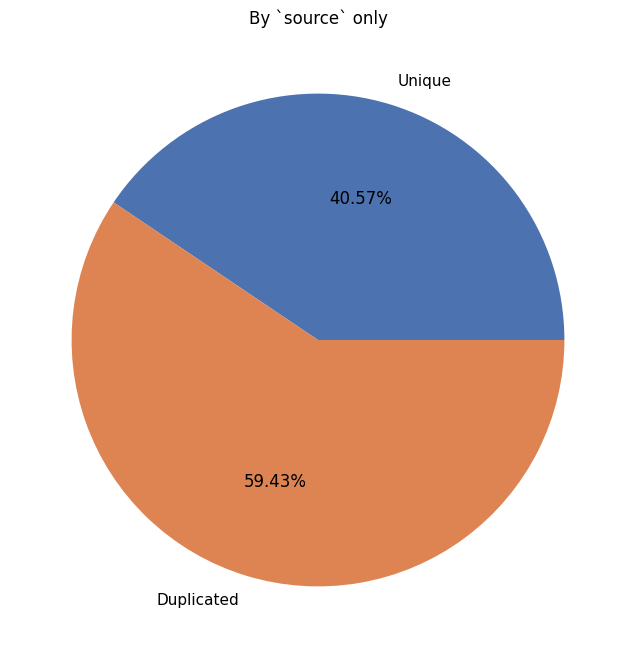

In [228]:
shader_df_dedup = shader_df.drop_duplicates(subset=['source'], keep='first')
tmp = len(shader_df_dedup) / len(shader_df) * 100
print("Percentage of all unique shaders: {:.2f}%".format(len(shader_df_dedup) / len(shader_df) * 100))
plt.figure(figsize=(8, 8))
plt.rcParams.update()
plt.pie([tmp, 100-tmp], labels=['Unique', 'Duplicated'], autopct='%.2f%%')
plt.title('By `source` only')
plt.show()

In [229]:
# list some duplicated shaders
tmp = shader_df[shader_df.source.duplicated(keep='first')]
print(len(tmp.url.unique()))
print(len(shader_df.url.unique()))
print(len(shader_df_dedup.url.unique()))

1577
2032
1699


In [300]:
tmp = shader_df.drop_duplicates(subset=['context_id', 'source'], keep='first')
tmp

,source,original,url,context_id,type,source_length
0,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,11123
1,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,6542
2,precisionhighpfloat;uniformmat4modelViewMatrix...,precision highp float;\nuniform mat4 modelView...,https://www.dangleterre.com/en/meetings-events...,0,vert,635
3,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,6556
4,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,11136
...,...,...,...,...,...,...
22447,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main() {gl_FragColor = vec4(1,0,0,1);}",http://vulkanbet.com/en/goodbye-notice,3449,frag,39
22448,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main() {gl_FragColor = vec4(1,0,0,1);}",http://vulkanbet.com/en/goodbye-notice,3450,frag,39
22449,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main() {gl_FragColor = vec4(1,0,0,1);}",http://vulkanbet.com/en/goodbye-notice,3451,frag,39
22450,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main() {gl_FragColor = vec4(1,0,0,1);}",http://vulkanbet.com/en/goodbye-notice,3452,frag,39


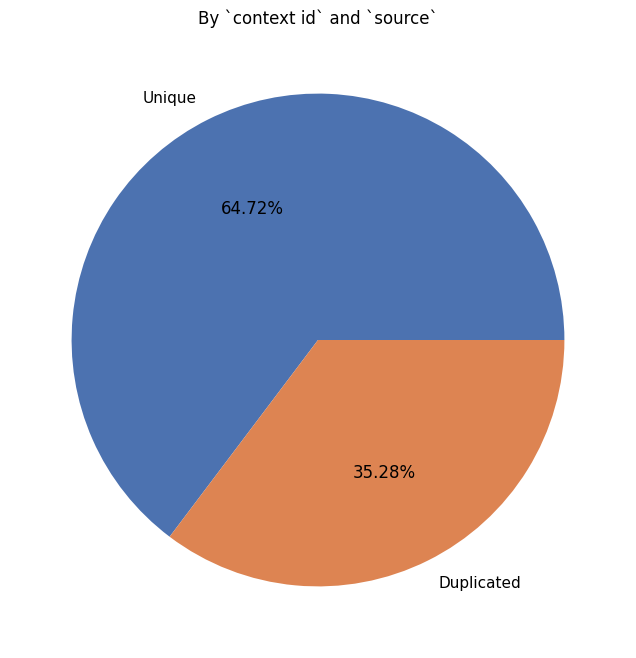

In [301]:
tmp = len(tmp) / len(shader_df) * 100
plt.figure(figsize=(8, 8))
plt.rcParams.update()
plt.pie([tmp, 100-tmp], labels=['Unique', 'Duplicated'], autopct='%.2f%%')
plt.title("By `context id` and `source`")
plt.show()

In [302]:
tmp = shader_df.drop_duplicates(subset=['source', 'url'], keep='first')
tmp

,source,original,url,context_id,type,source_length
0,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,11123
1,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,6542
2,precisionhighpfloat;uniformmat4modelViewMatrix...,precision highp float;\nuniform mat4 modelView...,https://www.dangleterre.com/en/meetings-events...,0,vert,635
3,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,6556
4,precisionhighpfloat;precisionhighpint;#defineV...,precision highp float;\nprecision highp int;\n...,https://www.dangleterre.com/en/meetings-events...,0,vert,11136
...,...,...,...,...,...,...
22437,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main(){gl_FragColor=vec4(1,0,0,1);}",https://www.wmj.ru/lyudi,3439,frag,39
22439,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main(){gl_FragColor=vec4(1,0,0,1);}",https://www.wmj.ru/lyudi/lnt-v-kalifornii-vyst...,3441,frag,39
22441,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main(){gl_FragColor=vec4(1,0,0,1);}",https://www.wmj.ru/news,3443,frag,39
22443,"voidmain(){gl_FragColor=vec4(1,0,0,1);}","void main(){gl_FragColor=vec4(1,0,0,1);}",https://www.wmj.ru/svetskaya-khronika/kak-pros...,3445,frag,39


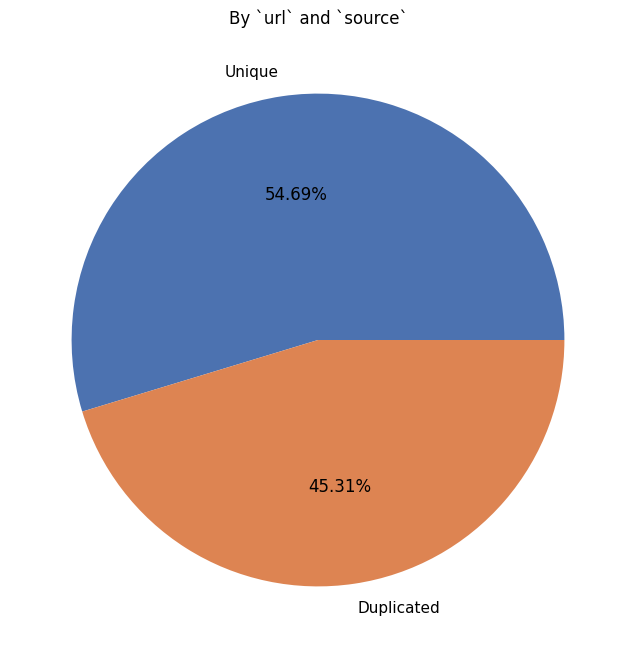

In [303]:
tmp = len(tmp) / len(shader_df) * 100
plt.figure(figsize=(8, 8))
plt.rcParams.update()
plt.pie([tmp, 100-tmp], labels=['Unique', 'Duplicated'], autopct='%.2f%%')
plt.title("By `url` and `source`")
plt.show()

## Shader Count

==0 count     2098.000000
mean       170.355100
std       1591.306178
min          1.000000
25%          2.000000
50%          5.000000
75%          8.000000
max      52511.000000
Name: total_func_call, dtype: float64
count    5094.000000
mean        8.815077
std        67.462632
min         0.000000
25%         0.000000
50%         2.000000
75%         8.000000
90%        18.000000
95%        34.000000
99%        88.140000
max      4482.000000
Name: shader_count, dtype: float64


,url,shader_count,program_count,_resources_shader,_resources_program
557,https://admireamaze.debijenkorf.nl/,4482,2242,4,2235


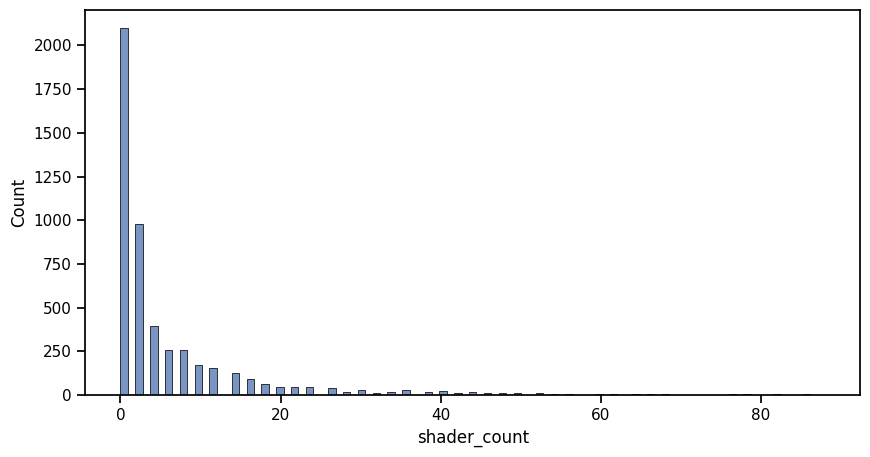

In [35]:
print('==0', fdf[fdf['shader_count'] == 0].total_func_call.describe())
# plot shader_count
tmp = fdf['shader_count'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(tmp)
plt.figure(figsize=(10, 5))
sns.histplot(data=fdf[fdf['shader_count'] < tmp['99%']], x="shader_count", multiple="stack")
plt.plot()
fdf[fdf['shader_count'] > 4000][['url', 'shader_count', 'program_count', '_resources_shader', '_resources_program']]


In [36]:
tmp = fdf_url.loc[fdf_url['shader_count']==0].copy()

In [37]:
# remove columns that sum=0
for x in tmp.columns:
    if tmp[x].sum() == 0:
        tmp.drop(x, axis=1, inplace=True)

In [38]:
tmp.to_excel(OUT_PATH / 'example' / 'shader_count_is_0.xlsx')

==0 count      624.000000
mean       371.841346
std       2706.521094
min          1.000000
25%          3.000000
50%          8.000000
75%         42.000000
max      52513.000000
Name: total_func_call, dtype: float64
count    2656.000000
mean       16.906627
std        93.745420
min         0.000000
25%         2.000000
50%         6.000000
75%        16.000000
90%        36.000000
95%        54.000000
99%       136.900000
max      4482.000000
Name: shader_count, dtype: float64


,shader_count,program_count,_resources_shader,_resources_program
url,,,,
https://admireamaze.debijenkorf.nl/,4482,2244,4,2235


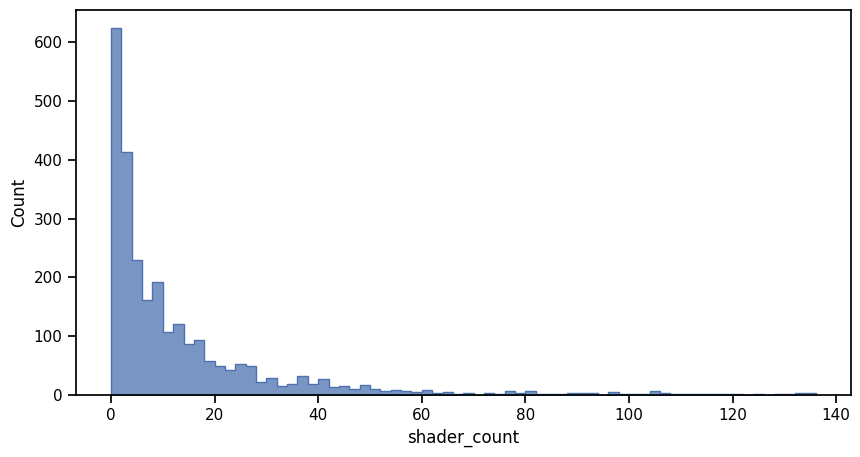

In [39]:
print('==0', fdf_url[fdf_url['shader_count'] == 0].total_func_call.describe())
# plot shader_count
tmp = fdf_url['shader_count'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(tmp)
plt.figure(figsize=(10, 5))
sns.histplot(data=fdf_url[fdf_url['shader_count'] < tmp['99%']], x="shader_count", element='step')
plt.plot()
fdf_url[fdf_url['shader_count'] > 4000][['shader_count', 'program_count', '_resources_shader', '_resources_program']]

## shader length

In [40]:
print(shader_df.source_length.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

count     44904.000000
mean       5566.663972
std       10492.478913
min          39.000000
25%         391.750000
50%        1296.000000
75%        6415.000000
90%       11493.000000
95%       31669.400000
99%       48657.940000
max      109735.000000
Name: source_length, dtype: float64


[]

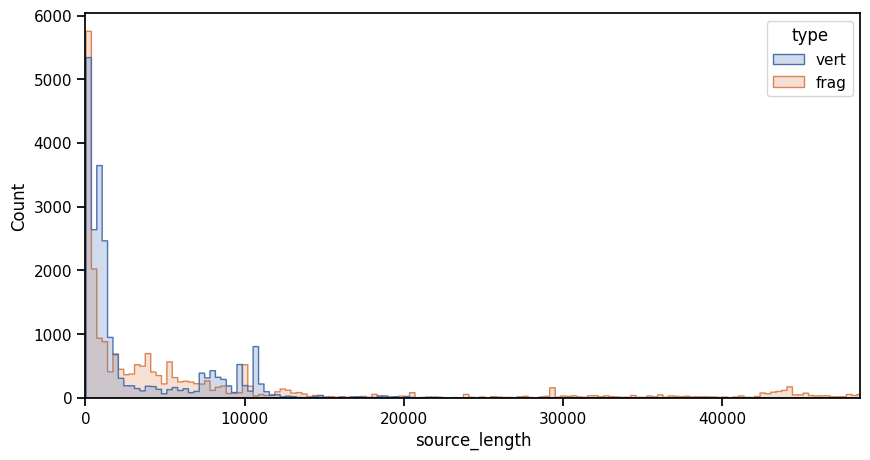

In [41]:
tmp = shader_df.source_length.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
plt.figure(figsize=(10, 5))
plt.xlim(0, tmp['99%'])
sns.histplot(data=shader_df, x="source_length", hue="type", multiple="layer", element="step")
plt.plot()

In [42]:
# vert, frag shaderlength median/ mean
shader_df_vert = shader_df[shader_df.type == 'vert']
shader_df_frag = shader_df[shader_df.type == 'frag']

print('vert', shader_df_vert.describe())
print('frag', shader_df_frag.describe())

vert        source_length
count   22452.000000
mean     2936.434037
std      3926.685377
min        41.000000
25%       393.000000
50%       984.000000
75%      4055.000000
max     27845.000000
frag        source_length
count   22452.000000
mean     8196.893907
std     13817.866615
min        39.000000
25%       359.000000
50%      2451.000000
75%      7701.000000
max    109735.000000


# Programs

count    5094.000000
mean        5.330781
std        33.698288
min         0.000000
25%         1.000000
50%         2.000000
75%         5.000000
90%        10.000000
95%        18.000000
99%        42.140000
max      2242.000000
Name: program_count, dtype: float64


[]

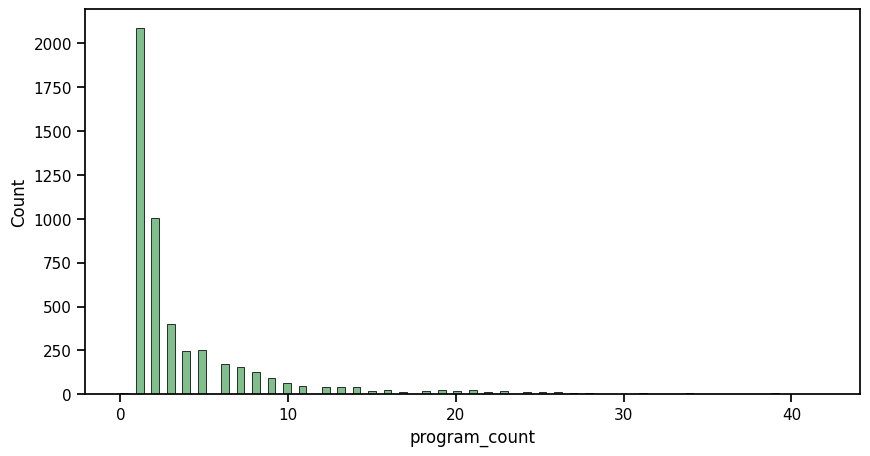

In [43]:
tmp = fdf['program_count'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(tmp)
plt.figure(figsize=(10, 5))
sns.histplot(data=fdf[fdf['program_count'] < tmp['99%']], x="program_count", multiple="stack", color=sns.color_palette()[2])
plt.plot()

# Textures

count    5094.000000
mean       10.114645
std        51.451275
min         0.000000
25%         0.000000
50%         2.000000
75%         6.000000
90%        20.000000
95%        39.000000
99%       138.350000
max      2314.000000
Name: _resources_texture, dtype: float64


,url,when,accessTime,whenDomContentLoadedEvent,whenLoadEvent,whenUsedWebgl,contextType,arg_alpha,arg_antialias,arg_depth,...,_func_call_isEnabled,_func_call_samplerParameterf,_func_call_samplerParameteri,arg_failIfMajorPerformanceCaviet,arg_transparent,_func_call_getUniform,arg_height,arg_width,arg_ignoreWebgl2,_func_call_isTexture
557,https://admireamaze.debijenkorf.nl/,32626.4,1679343872683,2432.9,6425.8,2164.6,webgl2,False,True,True,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0


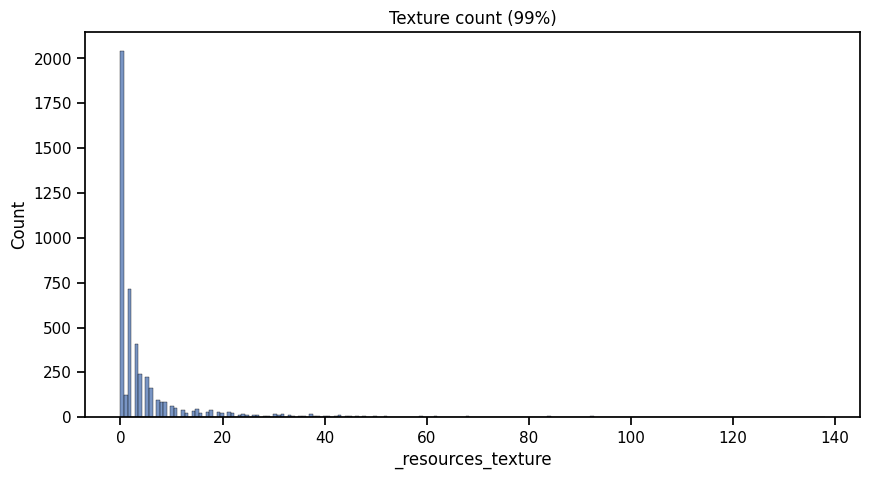

In [44]:
# plot shader_count
tmp = fdf['_resources_texture'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(tmp)
plt.figure(figsize=(10, 5))
plt.title('Texture count (99%)')
sns.histplot(data=fdf[fdf['_resources_texture'] < tmp['99%']], x="_resources_texture", multiple="stack")
plt.plot()
fdf[fdf['_resources_texture'] > 2000]

count    5094.000000
mean       10.698272
std        52.321716
min         0.000000
25%         0.000000
50%         2.000000
75%         6.000000
90%        22.000000
95%        43.000000
99%       156.420000
max      2314.000000
Name: _func_call_createTexture, dtype: float64


,url,when,accessTime,whenDomContentLoadedEvent,whenLoadEvent,whenUsedWebgl,contextType,arg_alpha,arg_antialias,arg_depth,...,_func_call_isEnabled,_func_call_samplerParameterf,_func_call_samplerParameteri,arg_failIfMajorPerformanceCaviet,arg_transparent,_func_call_getUniform,arg_height,arg_width,arg_ignoreWebgl2,_func_call_isTexture
557,https://admireamaze.debijenkorf.nl/,32626.4,1679343872683,2432.9,6425.8,2164.6,webgl2,False,True,True,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0


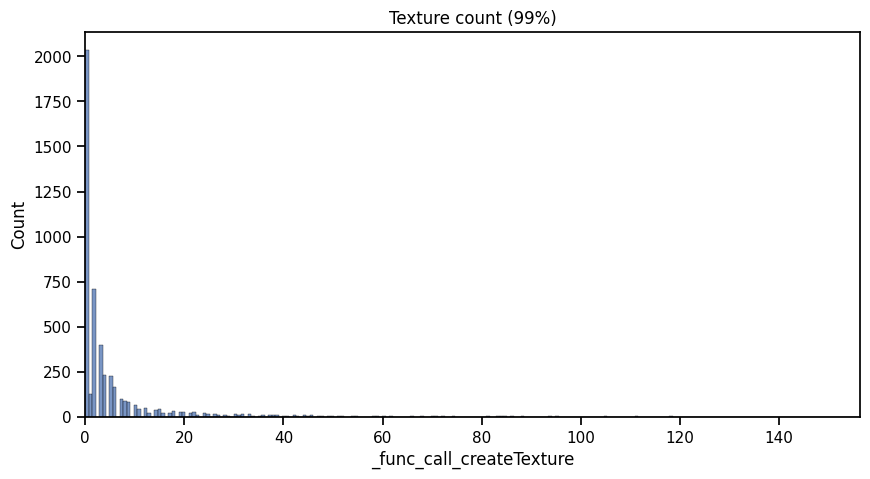

In [45]:
# plot shader_count
tmp = fdf['_func_call_createTexture'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(tmp)
plt.figure(figsize=(10, 5))
plt.xlim(0, tmp['99%'])
plt.title('Texture count (99%)')
sns.histplot(data=fdf, x="_func_call_createTexture", multiple="stack")
# sns.histplot(data=fdf_after, x="_resources_shader", multiple="stack")
plt.plot()
fdf[fdf['_func_call_createTexture'] > 2000]

# VAO

count     5094.000000
mean        20.739105
std        423.887443
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
90%          8.000000
95%         35.000000
99%        220.280000
max      26001.000000
Name: _func_call_createVertexArray, dtype: float64


,url,when,accessTime,whenDomContentLoadedEvent,whenLoadEvent,whenUsedWebgl,contextType,arg_alpha,arg_antialias,arg_depth,...,_func_call_isEnabled,_func_call_samplerParameterf,_func_call_samplerParameteri,arg_failIfMajorPerformanceCaviet,arg_transparent,_func_call_getUniform,arg_height,arg_width,arg_ignoreWebgl2,_func_call_isTexture
2,http://127.0.0.1:8000/test3/webgl/medium,31640.2,1679326403021,1228.5,1228.7,1024.6,webgl2,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
19,https://hydrogen.shopify.dev/,32187.5,1679359998547,1274.9,3064.4,1820.5,webgl2,True,True,True,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
26,https://universo.creatividadargentina.org/,37136.8,1679385108373,6609.8,10403.9,6705.1,webgl2,True,True,True,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
416,http://127.0.0.1:8000/test3/webgl/hard,31591.8,1679326369604,2276.0,2276.1,1581.2,webgl2,0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0
562,https://warszawskiul.com/en/,38258.9,1679388070574,7859.0,7864.4,7902.9,webgl2,True,False,True,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0


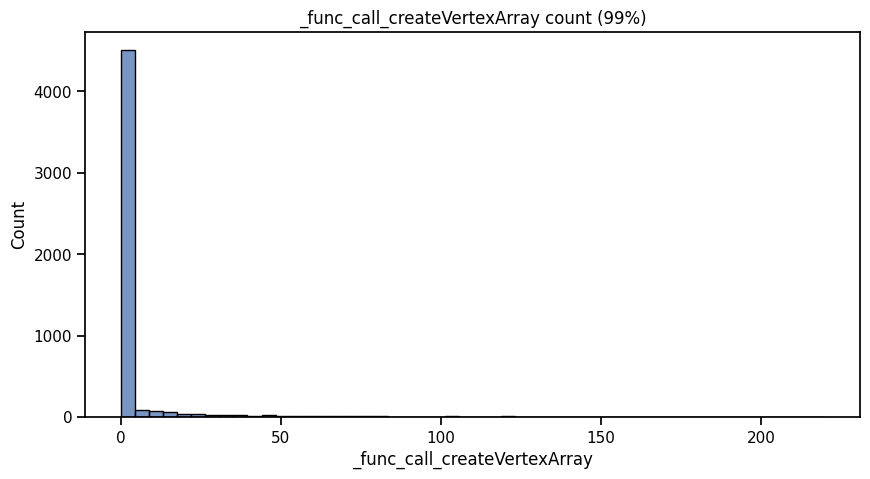

In [46]:
# plot shader_count
tmp = fdf['_func_call_createVertexArray'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(tmp)
plt.figure(figsize=(10, 5))
plt.title('_func_call_createVertexArray count (99%)')
sns.histplot(data=fdf[fdf['_func_call_createVertexArray'] < tmp['99%']], x="_func_call_createVertexArray", multiple="stack", bins=50)
# sns.histplot(data=fdf_after, x="_resources_shader", multiple="stack")
plt.plot()
fdf[fdf['_func_call_createVertexArray'] > 2000]

# Memory Total (roughly)

count    5.094000e+03
mean     6.432686e+07
std      1.182571e+08
min      0.000000e+00
25%      1.080000e+06
50%      2.038490e+07
75%      8.613054e+07
90%      1.654314e+08
95%      2.612116e+08
99%      5.895384e+08
max      1.792194e+09
Name: _memory_total, dtype: float64


[]

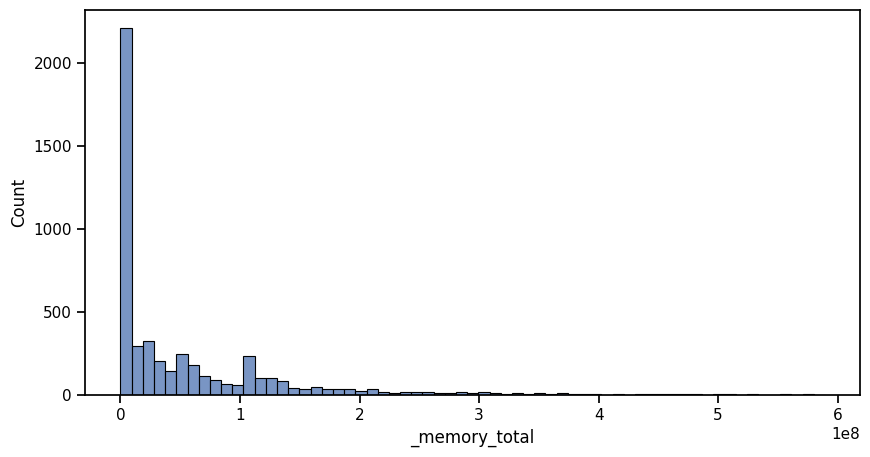

In [47]:
tmp = fdf['_memory_total'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(tmp)
plt.figure(figsize=(10, 5))
sns.histplot(data=fdf[fdf['_memory_total'] < tmp['99%']], x="_memory_total", multiple="stack")
plt.plot()

# Vertex & Triangle

In [48]:
fdf['vertexCount'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    5.094000e+03
mean     8.779588e+07
std      6.230141e+08
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+01
75%      3.226200e+06
90%      1.140264e+08
95%      3.370222e+08
99%      1.706604e+09
max      2.579857e+10
Name: vertexCount, dtype: float64

In [49]:
fdf[fdf['vertexCount'] == 0][['url', '_func_call_drawElements', '_func_call_drawArrays', '_func_call_drawBuffers', '_func_call_drawElementsInstanced', '_func_call_drawArraysInstanced']]

,url,_func_call_drawElements,_func_call_drawArrays,_func_call_drawBuffers,_func_call_drawElementsInstanced,_func_call_drawArraysInstanced
124,https://yar-studio.com/,249331.0,29860.0,2986.0,4479.0,0.0
125,https://jet.style/portfolio/case/promo-page-of...,0.0,0.0,0.0,78772.0,0.0
416,http://127.0.0.1:8000/test3/webgl/hard,0.0,0.0,1.0,0.0,0.0
499,https://tismes.com/,30670.0,1805.0,0.0,12204.0,0.0
510,https://artsexperiments.withgoogle.com/diving-...,0.0,4200.0,0.0,0.0,0.0
...,...,...,...,...,...,...
5089,https://www.thefemalegaze.art/,0.0,0.0,0.0,0.0,0.0
5090,https://www.thefemalegaze.art/,0.0,0.0,0.0,0.0,0.0
5091,https://www.thefemalegaze.art/,0.0,0.0,0.0,0.0,0.0
5092,https://www.thoughtlab.com/,0.0,0.0,0.0,0.0,0.0


In [50]:
fdf['triangleCount'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    5.094000e+03
mean     2.656129e+07
std      2.028820e+08
min     -1.640000e+02
25%      0.000000e+00
50%      2.000000e+00
75%      3.296235e+05
90%      2.913075e+07
95%      9.769364e+07
99%      5.146489e+08
max      8.598965e+09
Name: triangleCount, dtype: float64

# RequestAnimationFrame(RAF)

count    5.094000e+03
mean     1.106333e+04
std      1.327623e+05
min      0.000000e+00
25%      5.670000e+02
50%      2.153000e+03
75%      5.398000e+03
90%      9.595600e+03
95%      1.507830e+04
99%      3.552548e+04
max      3.999917e+06
Name: rafCalled_total, dtype: float64


[]

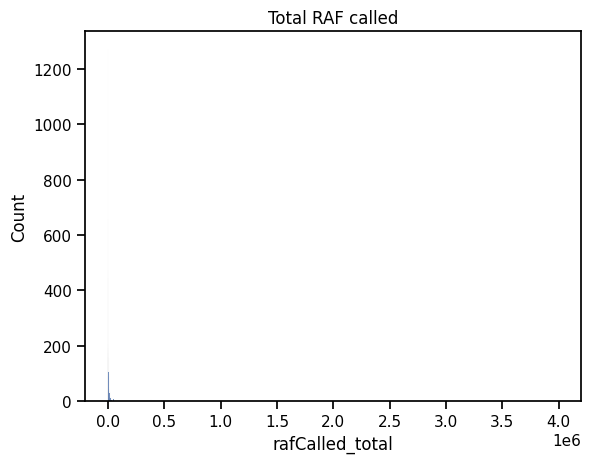

In [51]:
print(fdf.rafCalled_total.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
sns.histplot(data=fdf, x="rafCalled_total", multiple="stack")
plt.title('Total RAF called')
plt.plot()

count    5.094000e+03
mean     8.346663e+03
std      1.320690e+05
min      0.000000e+00
25%      7.300000e+01
50%      9.795000e+02
75%      2.151000e+03
90%      4.972700e+03
95%      5.448000e+03
99%      1.330665e+04
max      3.998313e+06
Name: rafCalled_max, dtype: float64


[]

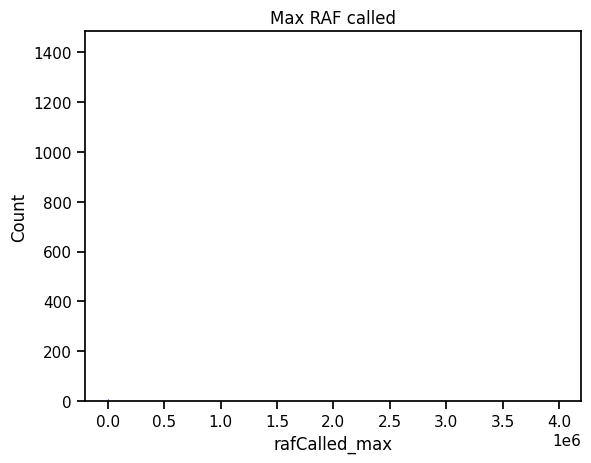

In [52]:
print(fdf.rafCalled_max.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
sns.histplot(data=fdf, x="rafCalled_max", multiple="stack")
plt.title('Max RAF called')
plt.plot()